In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Load your dataset
df = pd.read_csv("CesDataClean4_subset.csv")

# 2. Define continuous variables to standardize
continuous_vars = ['egrea_imean_bt', 'egrea_istd_bt', 'lhhnetinc', 'age']

# 3. Initialize and apply the scaler
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

# 4. Define asset share variables
liquid_vars = ['sh_sav_wave9', 'sh_stock_wave9', 'sh_mutf_wave9']
illiquid_vars = ['sh_ira_wave9', 'sh_bond_wave9', 'sh_oth_wave9']

# 5. Create composite variables for liquid and illiquid assets
df['LiquidAssets'] = df[liquid_vars].sum(axis=1)
df['IlliquidAssets'] = df[illiquid_vars].sum(axis=1)

# 6. Verify the transformation
print(df[['LiquidAssets', 'IlliquidAssets']].describe())

# 7. Save the cleaned and standardized dataset
df.to_csv("CesDataClean4_subset_standardized4.csv", index=False)
print("✅ File saved as 'CesDataClean4_subset_standardized4.csv'")


       LiquidAssets  IlliquidAssets
count   3309.000000     3309.000000
mean       0.738229        0.261771
std        0.318637        0.318637
min        0.000000        0.000000
25%        0.502581        0.000000
50%        0.917246        0.082754
75%        1.000000        0.497419
max        1.000000        1.000000
✅ File saved as 'CesDataClean4_subset_standardized4.csv'


In [15]:
import pandas as pd

# 1. Load dataset
df = pd.read_csv("CesDataClean4_subset_standardized4.csv")

# 2. Define rename mapping
rename_map = {
    'cons_tot_wave10': 'Total Monthly Consumption Oct. 2020',
    'cons_tot_wave13': 'Total Monthly Consumption Jan. 2021',
    'treat1': 'Control Group',
    'treat2': 'First Moment Treatment',
    'treat3': 'Second Moment Europe Treatment',
    'treat4': 'First & Second Moment Treatment',
    'treat5': 'Second Moment Domestic Treatment',
    'egrea_imean_bt': 'Europe Mean Growth Expectation Prior',
    'egrea_istd_bt': 'Europe Uncertainty in Growth Expectation Prior',
    'lhhnetinc': 'Log Net Household Income Sep. 2020',
    'cnt1': 'Belgian',
    'cnt2': 'Danish',
    'cnt3': 'Spanish',
    'cnt4': 'French',
    'cnt5': 'Italian',
    'cnt6': 'Dutch',
    'hhsize': 'Household Size',
    'male': 'Male',
    'dedu2': 'High-School Educated',
    'dedu3': 'Post-Secondary Educated',
    'age': 'Age',
    'liquid_wave9': 'Sufficient Liquidity'
}

# 3. Rename variables
df.rename(columns=rename_map, inplace=True)

# 4. Drop the specified columns
drop_cols = ['sh_sav_wave9', 'sh_stock_wave9', 'sh_mutf_wave9', 
             'sh_ira_wave9', 'sh_bond_wave9', 'sh_oth_wave9', 'Belgian', 'Danish', 'Spanish', 'Italian', 'Dutch', 'French']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# 5. Save the cleaned dataset
df.to_csv("CesDataClean4ASNoCountries.csv", index=False)
print("✅ File saved as 'CesDataClean4ASNoCountries.csv'")


✅ File saved as 'CesDataClean4ASNoCountries.csv'


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1131296744.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


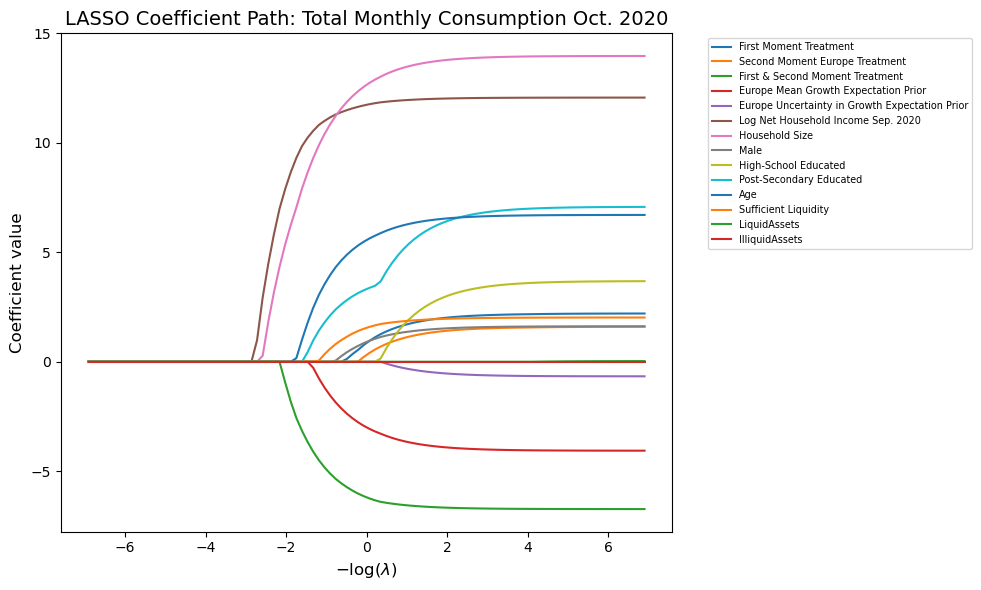

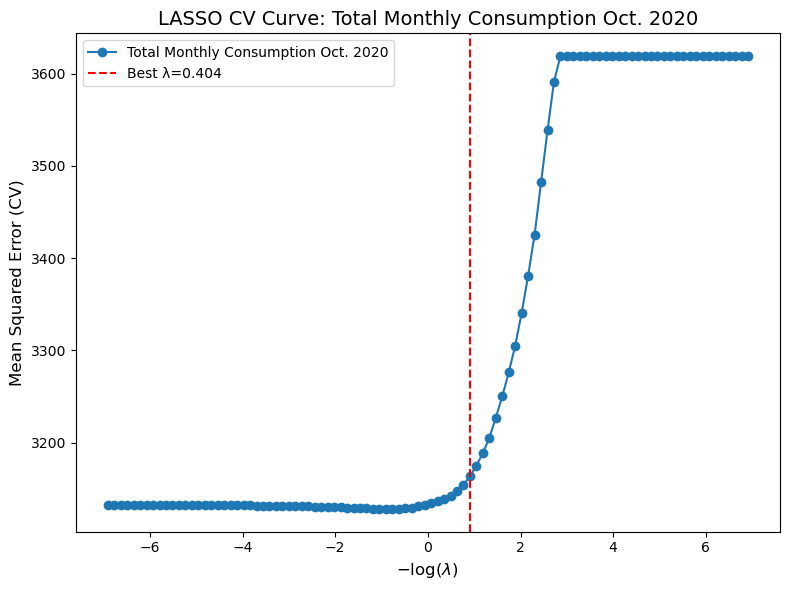

✅ Saved and displayed: lasso_wave10_coeff_path2 and lasso_wave10_cv_curve2


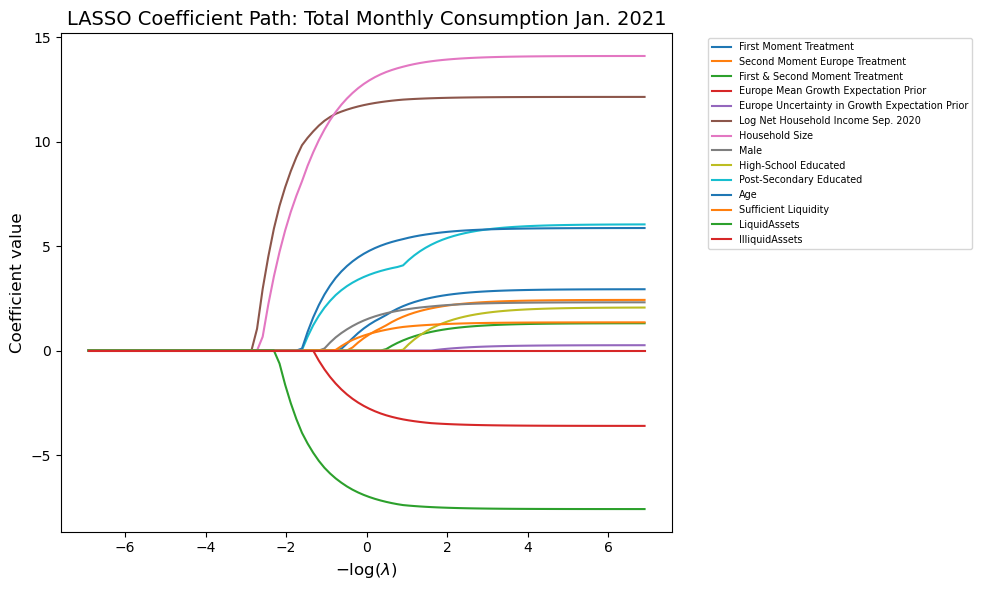

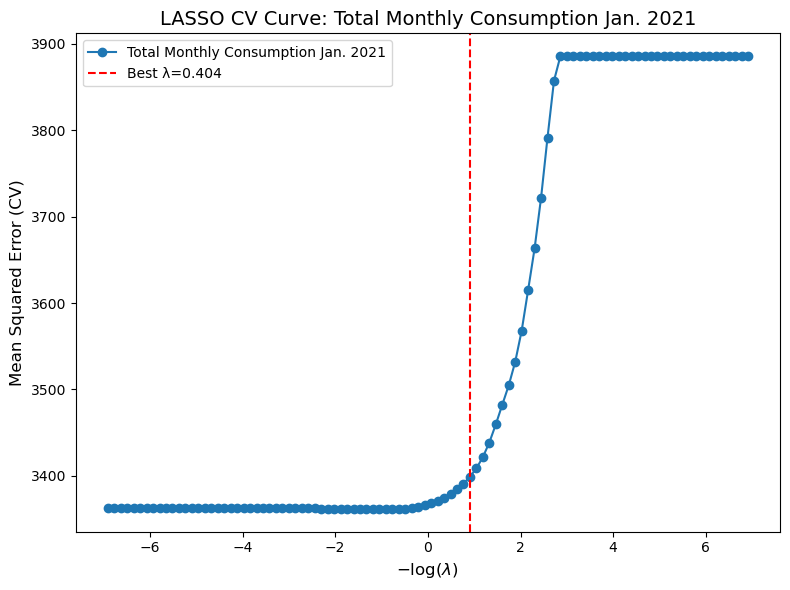

✅ Saved and displayed: lasso_wave13_coeff_path2 and lasso_wave13_cv_curve2


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("CesDataClean4ASNoCountries.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthly Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthly Consumption Oct. 2020", 
    "Total Monthly Consumption Jan. 2021", 
    "Control Group"
]]

# Dependent variables
y1 = 100 * np.log(df_filtered["Total Monthly Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

X_filtered = df_filtered[predictors].astype(float)

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

# LASSO settings
alphas = np.logspace(-3, 3, 100)

def lasso_path_and_cv(X, y, label, filename_prefix):
    # === Coefficient paths ===
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)

    plt.figure(figsize=(10, 6))
    for i, col in enumerate(X.columns):
        plt.plot(-np.log(alphas), coefs[:, i], label=col)
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"LASSO Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    #plt.savefig(f"{filename_prefix}_coeff_path.pdf2")
    #plt.savefig(f"{filename_prefix}_coeff_path.png2", dpi=300)
    plt.show()  # <-- Display the graph inline
    plt.close()

    # === Cross-validation curve ===
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)

    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"LASSO CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"{filename_prefix}_cv_curve2.pdf")
    #plt.savefig(f"{filename_prefix}_cv_curve2.png", dpi=300)
    plt.show()  # <-- Display the graph inline
    plt.close()

    print(f"✅ Saved and displayed: {filename_prefix}_coeff_path2 and {filename_prefix}_cv_curve2")

# Run for both outcomes
lasso_path_and_cv(X_scaled, y1, "Total Monthly Consumption Oct. 2020", "lasso_wave10")
lasso_path_and_cv(X_scaled, y2, "Total Monthly Consumption Jan. 2021", "lasso_wave13")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\630613393.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


✅ Added Top20Dummy and Bottom20Dummy (not saved to file).

=== Running LASSO for Top 20% group ===


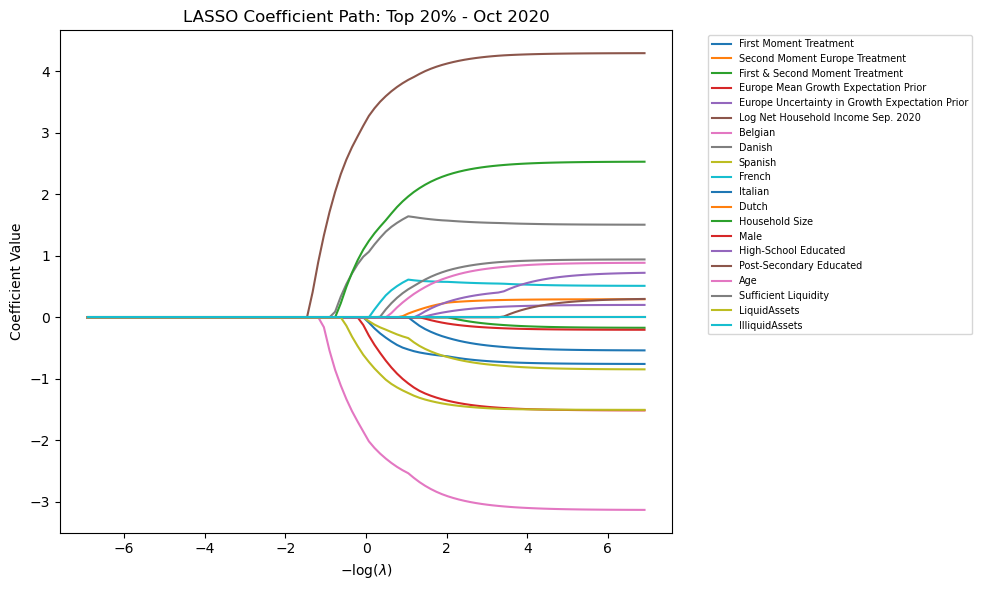

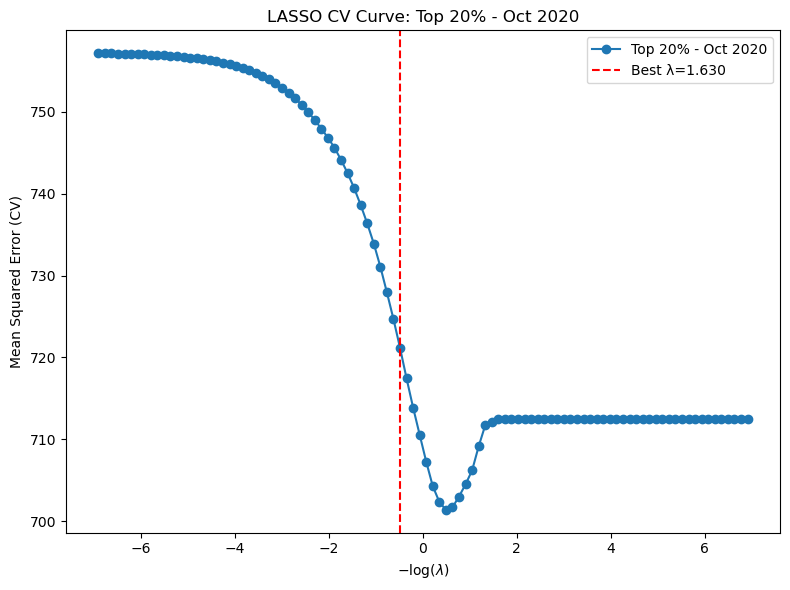

✅ Displayed LASSO paths for Top 20% - Oct 2020


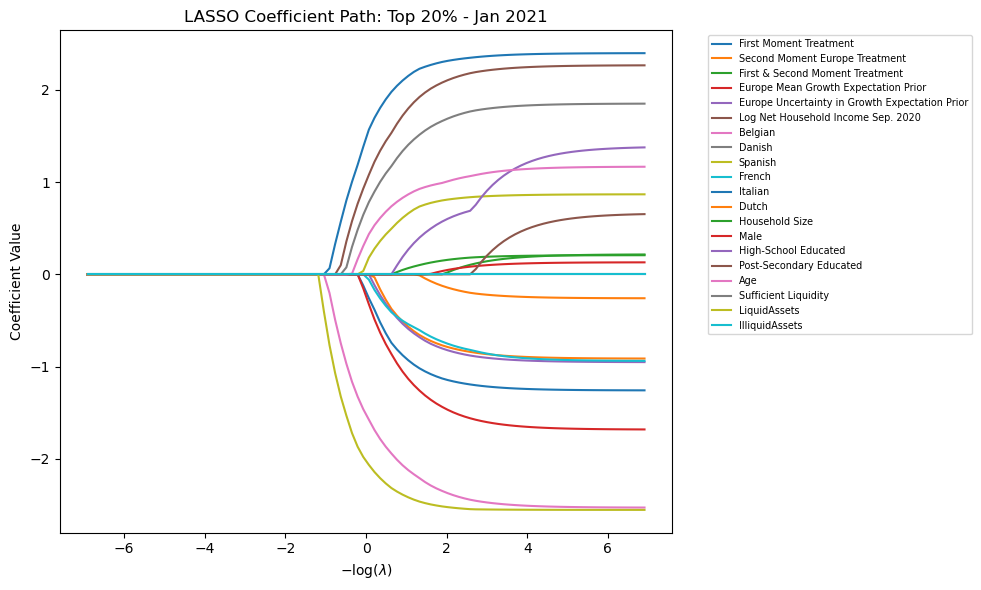

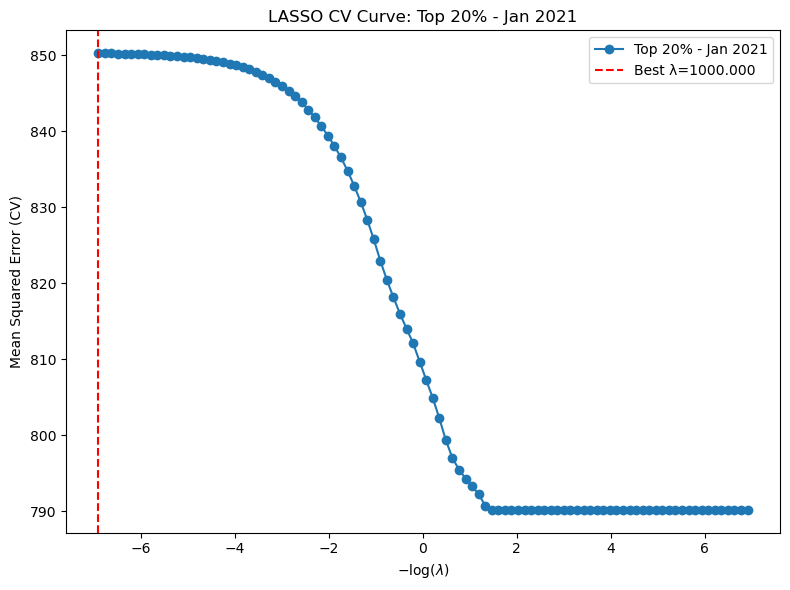

✅ Displayed LASSO paths for Top 20% - Jan 2021

=== Running LASSO for Bottom 20% group ===


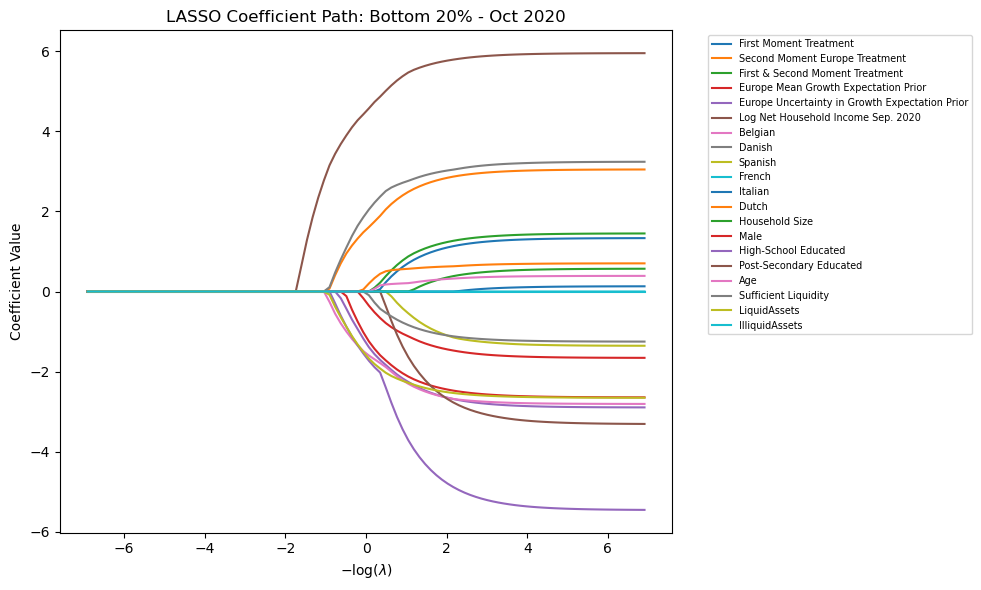

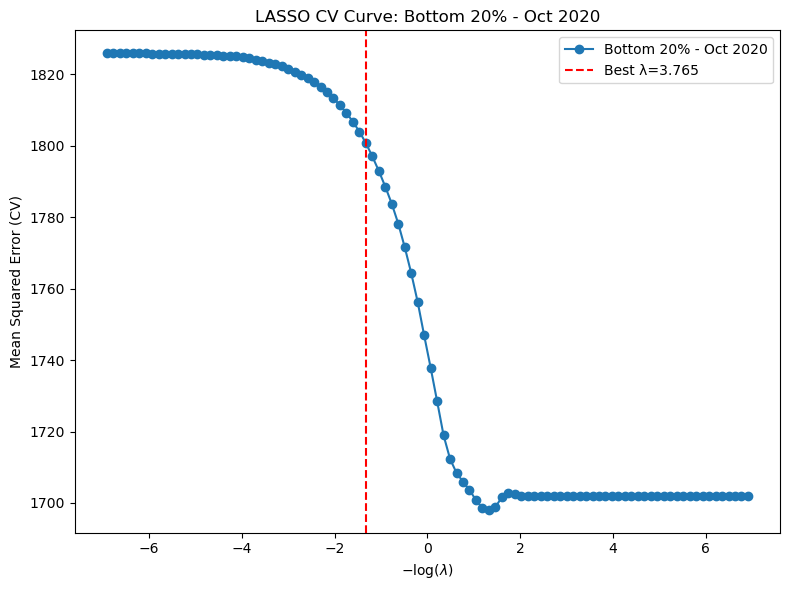

✅ Displayed LASSO paths for Bottom 20% - Oct 2020


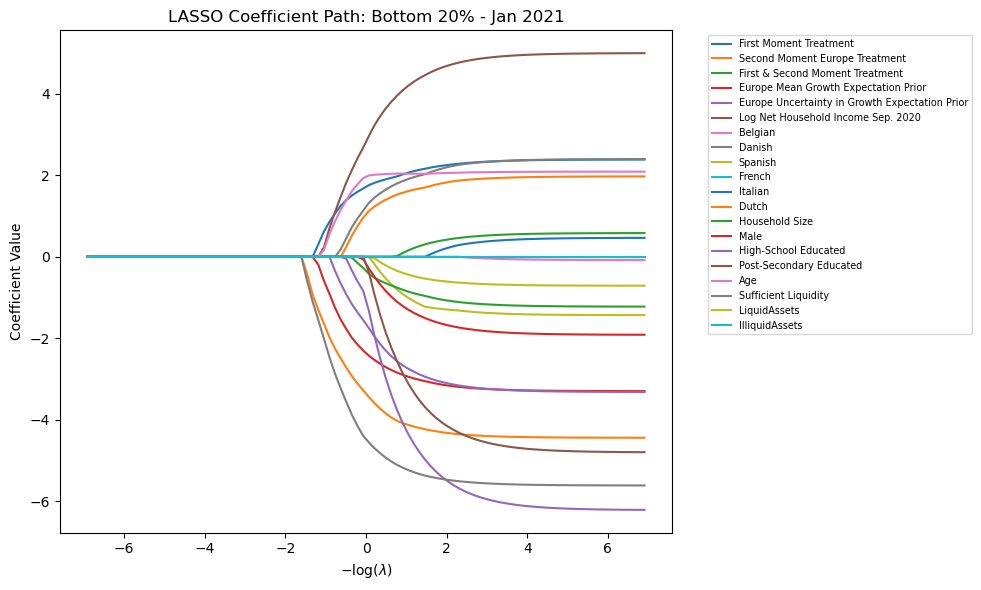

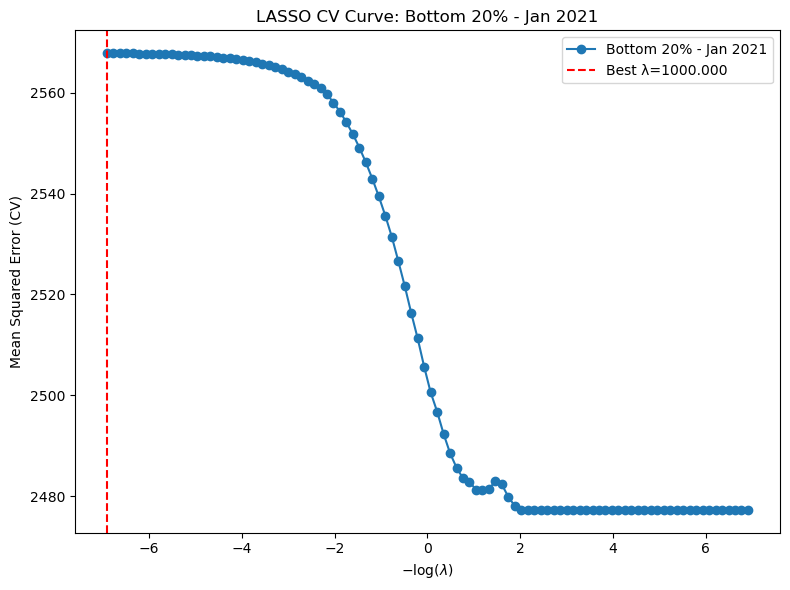

✅ Displayed LASSO paths for Bottom 20% - Jan 2021


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# === 1. Load the dataset ===
df = pd.read_csv("CesDataClean4AS.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if it exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# === 2. Create Top and Bottom 20% Dummies ===
top20_oct = df["Total Monthly Consumption Oct. 2020"].quantile(0.80)
top20_jan = df["Total Monthly Consumption Jan. 2021"].quantile(0.80)

bottom20_oct = df["Total Monthly Consumption Oct. 2020"].quantile(0.20)
bottom20_jan = df["Total Monthly Consumption Jan. 2021"].quantile(0.20)

df["Top20Dummy"] = np.where(
    (df["Total Monthly Consumption Oct. 2020"] >= top20_oct) &
    (df["Total Monthly Consumption Jan. 2021"] >= top20_jan), 1, 0)

df["Bottom20Dummy"] = np.where(
    (df["Total Monthly Consumption Oct. 2020"] <= bottom20_oct) &
    (df["Total Monthly Consumption Jan. 2021"] <= bottom20_jan), 1, 0)

# Save updated dataset
# df.to_csv("CesDataClean4AS_withDummies.csv", index=False)
print("✅ Added Top20Dummy and Bottom20Dummy (not saved to file).")

# === 3. Define LASSO helper function ===
alphas = np.logspace(-3, 3, 100)

def lasso_path_and_cv(X, y, label, filename_prefix):
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)

    # Coefficient path plot
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(X.columns):
        plt.plot(-np.log(alphas), coefs[:, i], label=col)
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Coefficient Value")
    plt.title(f"LASSO Coefficient Path: {label}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    # plt.savefig(f"{filename_prefix}_coeff_path.pdf")
    # plt.savefig(f"{filename_prefix}_coeff_path.png", dpi=300)
    plt.show()
    plt.close()

    # Cross-validation plot
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)
    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=label)
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Mean Squared Error (CV)")
    plt.title(f"LASSO CV Curve: {label}")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"{filename_prefix}_cv_curve.pdf")
    # plt.savefig(f"{filename_prefix}_cv_curve.png", dpi=300)
    plt.show()
    plt.close()

    print(f"✅ Displayed LASSO paths for {label}")

# === 4. Run LASSO for top and bottom groups ===
for group_label, group_col in [("Top 20%", "Top20Dummy"), ("Bottom 20%", "Bottom20Dummy")]:
    df_group = df[df[group_col] == 1].copy()

    if len(df_group) < 10:
        print(f"⚠️ Not enough observations in {group_label} group.")
        continue

    df_group = df_group[(df_group["Total Monthly Consumption Oct. 2020"] <= 10000) &
                        (df_group["Total Monthly Consumption Jan. 2021"] <= 10000)]

    predictors = [col for col in df_group.columns if col not in [
        "Total Monthly Consumption Oct. 2020",
        "Total Monthly Consumption Jan. 2021",
        "Control Group",
        "Top20Dummy",
        "Bottom20Dummy"
    ]]

    y1 = 100 * np.log(df_group["Total Monthly Consumption Oct. 2020"].astype(float))
    y2 = 100 * np.log(df_group["Total Monthly Consumption Jan. 2021"].astype(float))

    X = df_group[predictors].astype(float)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    print(f"\n=== Running LASSO for {group_label} group ===")
    lasso_path_and_cv(X_scaled, y1, f"{group_label} - Oct 2020", f"lasso_topbot_wave10_{group_label}")
    lasso_path_and_cv(X_scaled, y2, f"{group_label} - Jan 2021", f"lasso_topbot_wave13_{group_label}")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\464332149.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\464332149.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Top20Dummy"] = top_20_mask.astype(int)
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\464332149.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

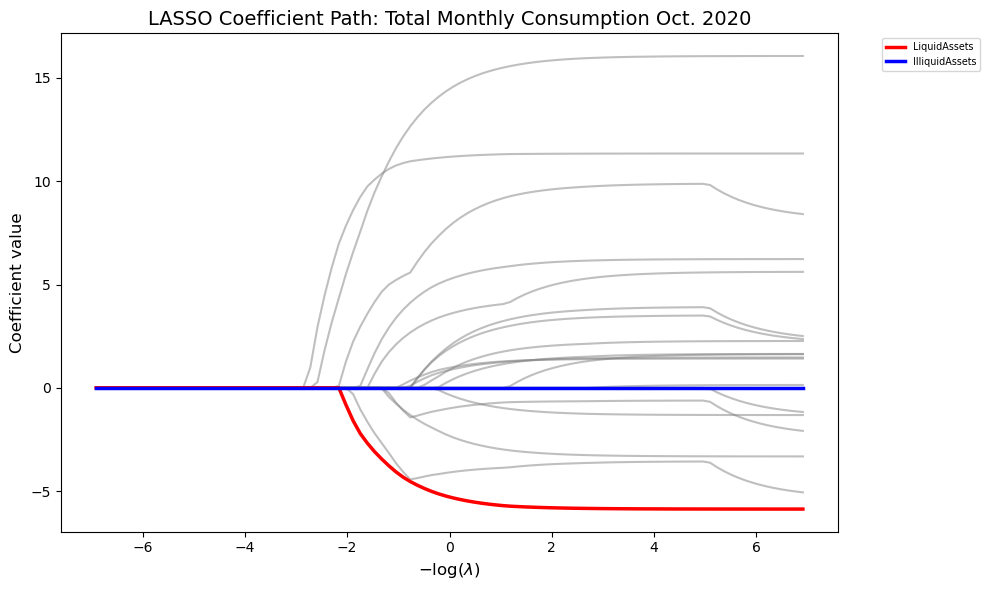

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.478e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(


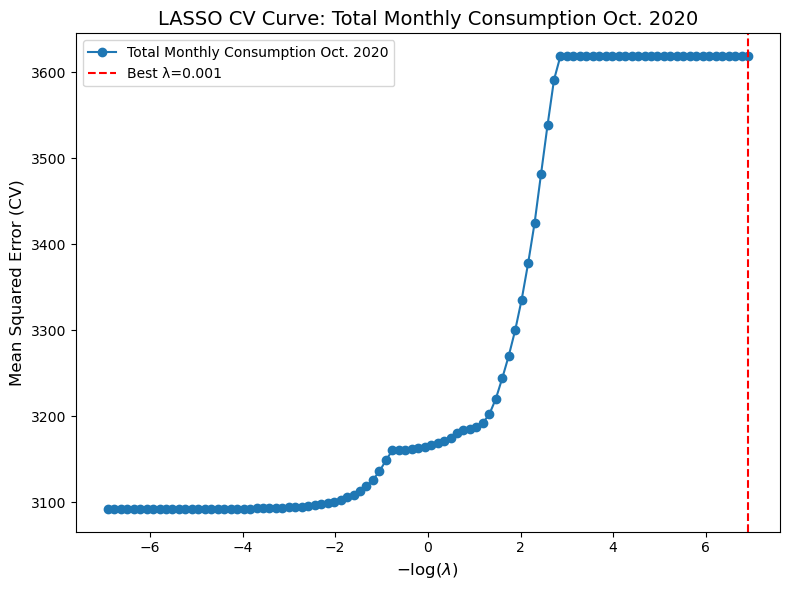

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.758e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.759e+03, tolerance: 

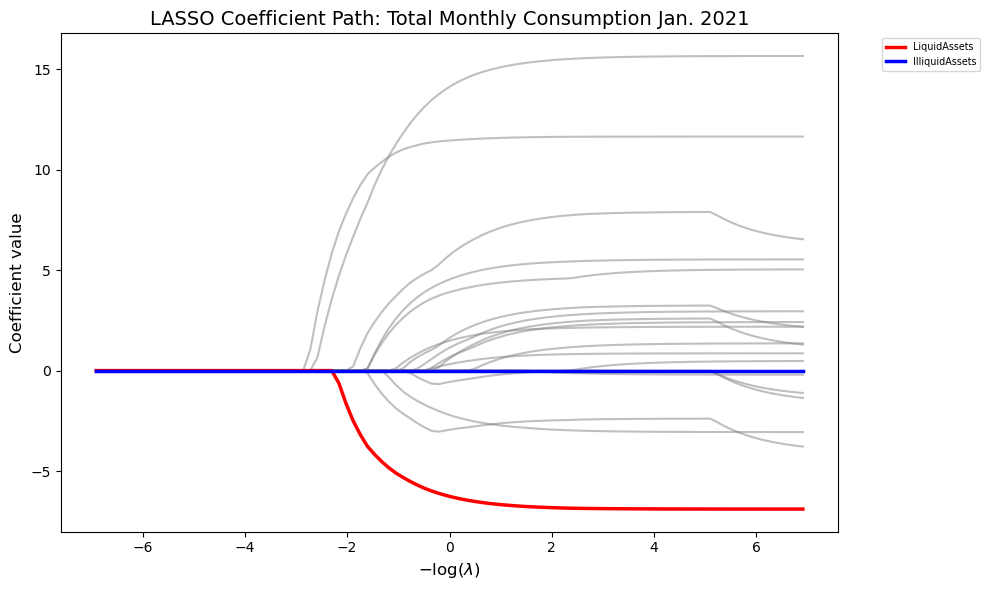

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(


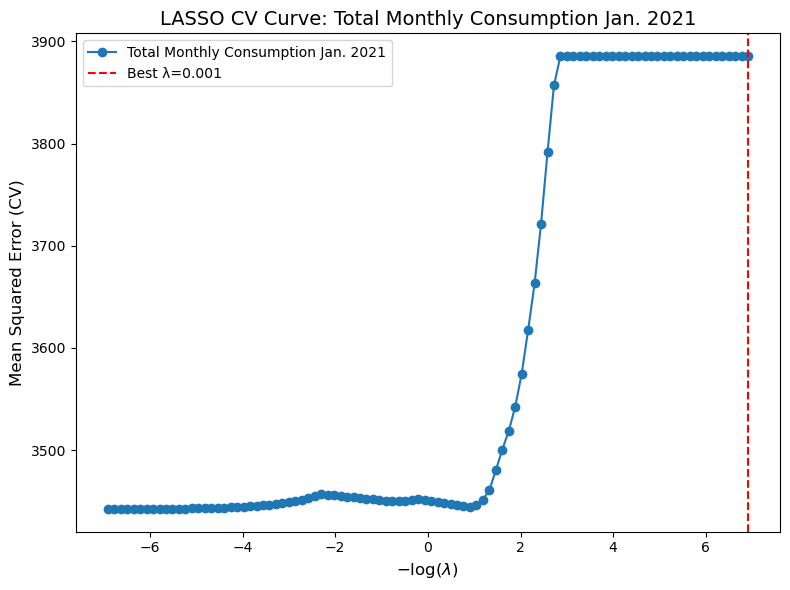

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthly Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthly Consumption Oct. 2020", 
    "Total Monthly Consumption Jan. 2021", 
    "Control Group"
]]

# Dependent variables
y1 = 100 * np.log(df_filtered["Total Monthly Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

X_filtered = df_filtered[predictors].astype(float)

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

# --- Create dummies for top/bottom 20% ---
top_20_mask = (df_filtered["Total Monthly Consumption Oct. 2020"] >= np.percentile(df_filtered["Total Monthly Consumption Oct. 2020"], 80)) & \
              (df_filtered["Total Monthly Consumption Jan. 2021"] >= np.percentile(df_filtered["Total Monthly Consumption Jan. 2021"], 80))
bottom_20_mask = (df_filtered["Total Monthly Consumption Oct. 2020"] <= np.percentile(df_filtered["Total Monthly Consumption Oct. 2020"], 20)) & \
                 (df_filtered["Total Monthly Consumption Jan. 2021"] <= np.percentile(df_filtered["Total Monthly Consumption Jan. 2021"], 20))

df_filtered["Top20Dummy"] = top_20_mask.astype(int)
df_filtered["Bottom20Dummy"] = bottom_20_mask.astype(int)

# Define LASSO parameters
alphas = np.logspace(-3, 3, 100)

def lasso_path_and_cv(X, y, label, filename_prefix):
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)

    # Highlight LiquidAssets and IlliquidAssets
    highlight_vars = {"LiquidAssets": "red", "IlliquidAssets": "blue"}

    plt.figure(figsize=(10, 6))
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(-np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(-np.log(alphas), coefs[:, i], color="gray", alpha=0.5)

    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"LASSO Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    # plt.savefig(f"{filename_prefix}_coeff_path.pdf")
    # plt.savefig(f"{filename_prefix}_coeff_path.png", dpi=300)
    plt.show()
    plt.close()

    # === Cross-validation ===
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)

    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"LASSO CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"{filename_prefix}_cv_curve.pdf")
    # plt.savefig(f"{filename_prefix}_cv_curve.png", dpi=300)
    plt.show()
    plt.close()

# Run for both consumption waves
lasso_path_and_cv(X_scaled, y1, "Total Monthly Consumption Oct. 2020", "lasso_wave10")
lasso_path_and_cv(X_scaled, y2, "Total Monthly Consumption Jan. 2021", "lasso_wave13")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2415085505.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


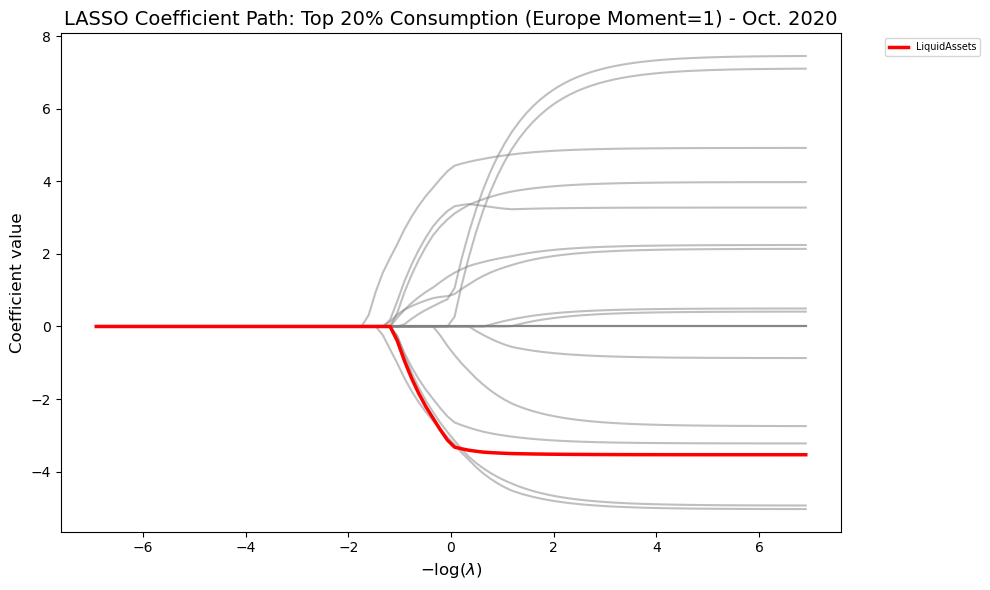

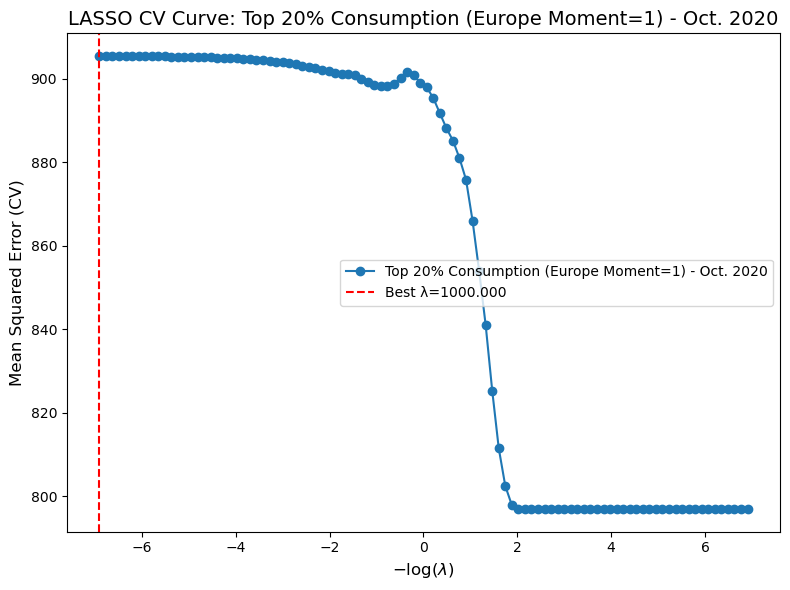

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.808e+01, tolerance: 6.390e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.811e+01, tolerance: 6.390e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.814e+01, tolerance: 

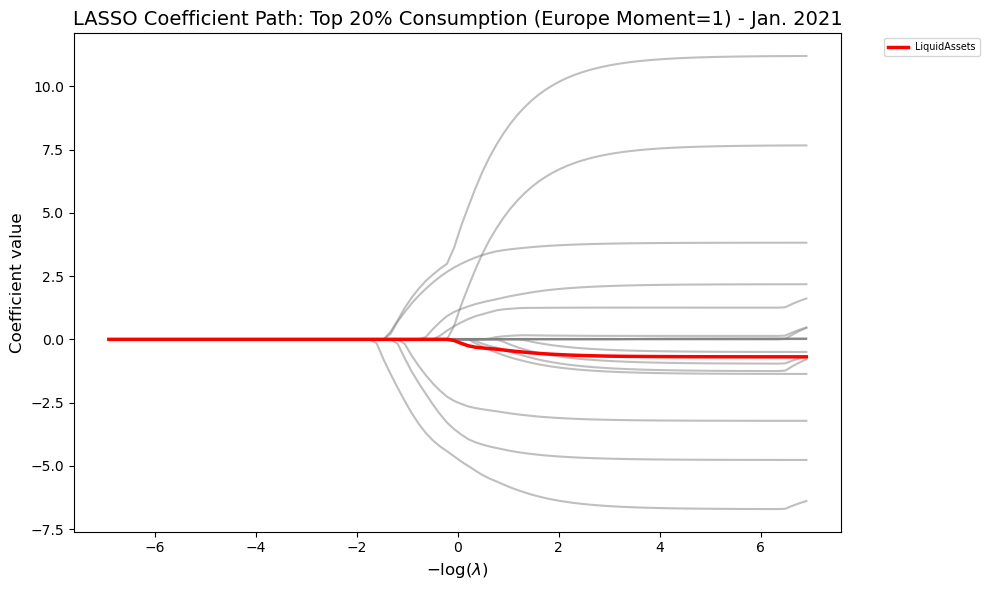

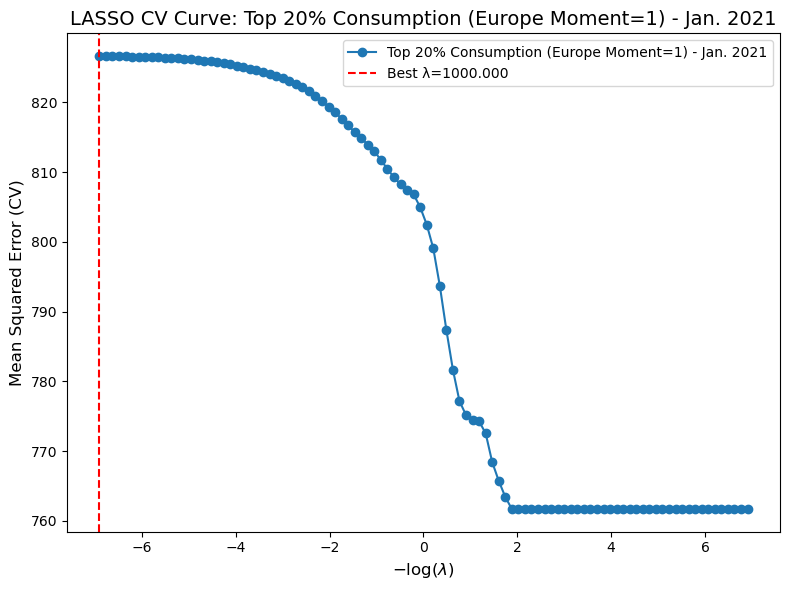

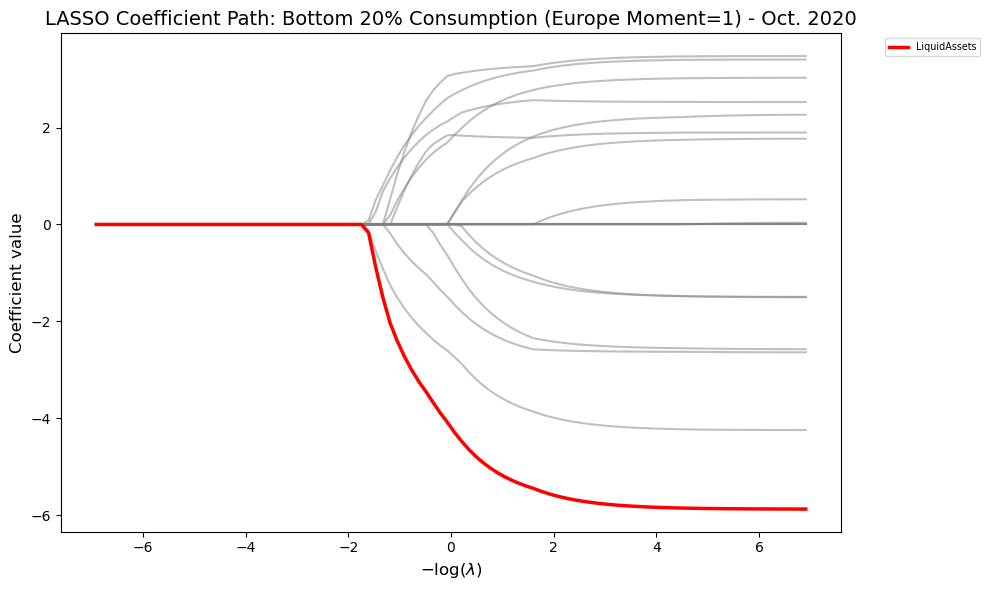

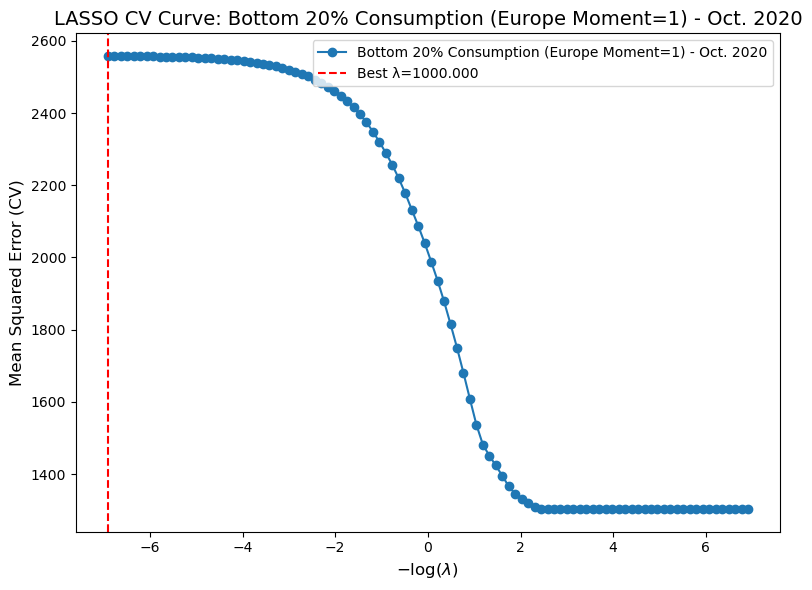

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e+04, tolerance: 4.348e+01
  model = cd_fast.enet_coordinate_descent(


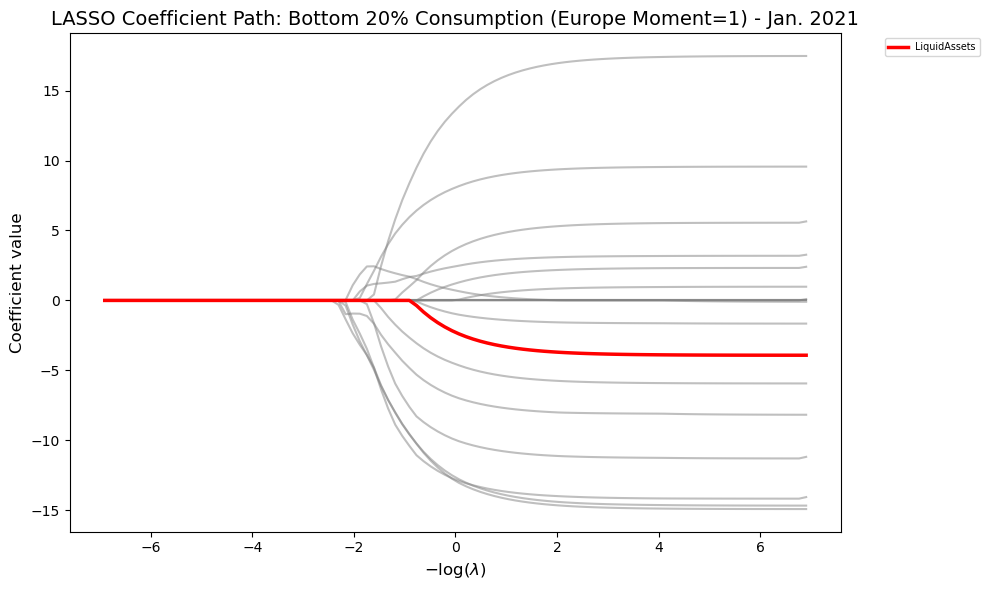

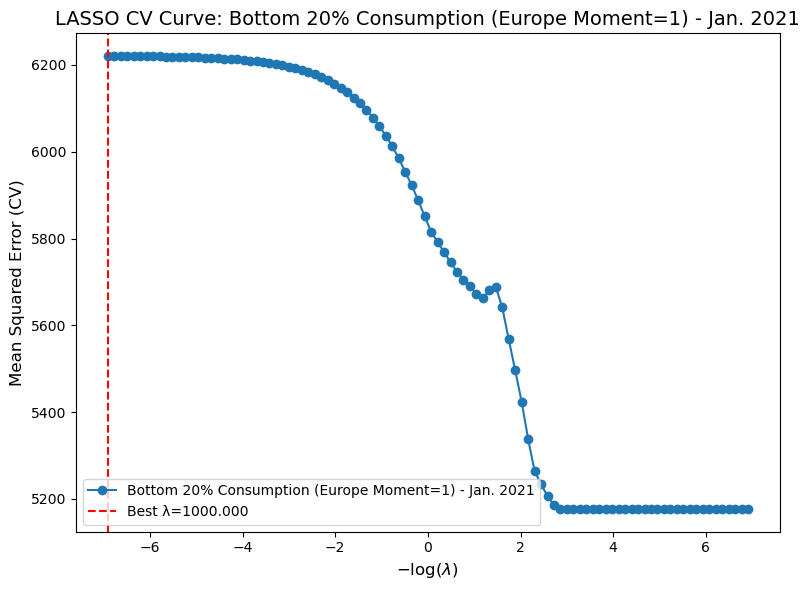

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Filter: only observations where Second Moment Europe Treatment == 1
df = df[df["Second Moment Europe Treatment"] == 1]

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Drop IlliquidAssets to avoid perfect multicollinearity
if "IlliquidAssets" in df.columns:
    df = df.drop(columns=["IlliquidAssets"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthly Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Compute top/bottom 20% masks based on consumption
top_20_mask = (df_filtered["Total Monthly Consumption Oct. 2020"] >= np.percentile(df_filtered["Total Monthly Consumption Oct. 2020"], 80)) & \
              (df_filtered["Total Monthly Consumption Jan. 2021"] >= np.percentile(df_filtered["Total Monthly Consumption Jan. 2021"], 80))

bottom_20_mask = (df_filtered["Total Monthly Consumption Oct. 2020"] <= np.percentile(df_filtered["Total Monthly Consumption Oct. 2020"], 20)) & \
                 (df_filtered["Total Monthly Consumption Jan. 2021"] <= np.percentile(df_filtered["Total Monthly Consumption Jan. 2021"], 20))

# Define LASSO parameters
alphas = np.logspace(-3, 3, 100)

def lasso_path_and_cv(X, y, label):
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)

    # Highlight LiquidAssets only
    highlight_vars = {"LiquidAssets": "red"}

    plt.figure(figsize=(10, 6))
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(-np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(-np.log(alphas), coefs[:, i], color="gray", alpha=0.5)

    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"LASSO Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    # plt.savefig(f"{label}_coeff_path.pdf")
    # plt.savefig(f"{label}_coeff_path.png", dpi=300)
    plt.show()
    plt.close()

    # Cross-validation
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)

    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"LASSO CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"{label}_cv_curve.pdf")
    # plt.savefig(f"{label}_cv_curve.png", dpi=300)
    plt.show()
    plt.close()

# Function to run LASSO for a mask
def run_lasso_for_mask(df_masked, description):
    predictors = [col for col in df_masked.columns if col not in [
        "Total Monthly Consumption Oct. 2020",
        "Total Monthly Consumption Jan. 2021",
        "Control Group"
    ]]
    X = df_masked[predictors].astype(float)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y1 = 100 * np.log(df_masked["Total Monthly Consumption Oct. 2020"].astype(float))
    y2 = 100 * np.log(df_masked["Total Monthly Consumption Jan. 2021"].astype(float))
    
    lasso_path_and_cv(X_scaled, y1, f"{description} - Oct. 2020")
    lasso_path_and_cv(X_scaled, y2, f"{description} - Jan. 2021")

# Run LASSO for top 20% consumption
run_lasso_for_mask(df_filtered[top_20_mask], "Top 20% Consumption (Europe Moment=1)")

# Run LASSO for bottom 20% consumption
run_lasso_for_mask(df_filtered[bottom_20_mask], "Bottom 20% Consumption (Europe Moment=1)")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\135391199.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


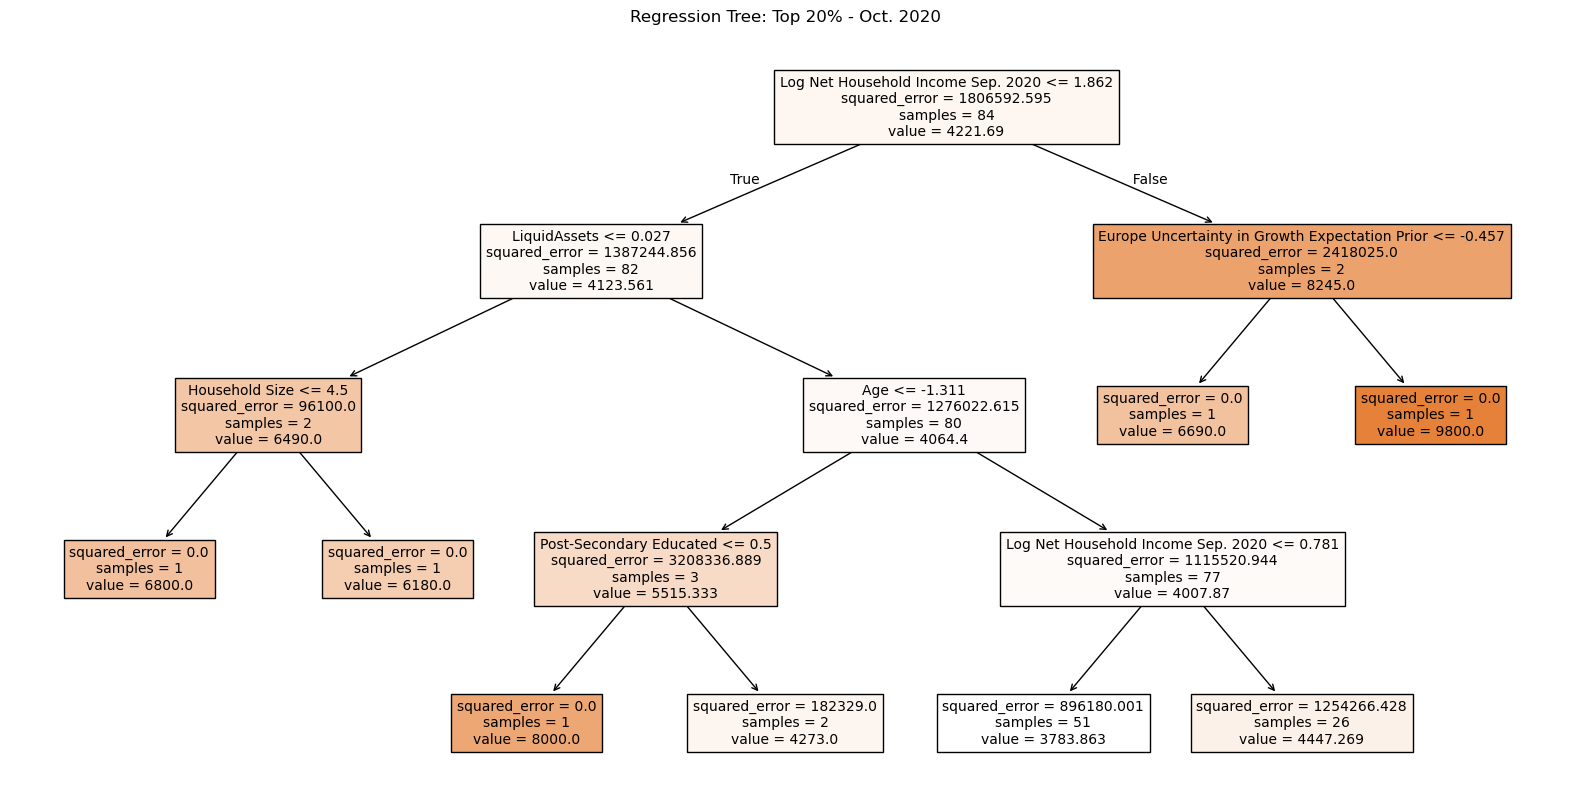

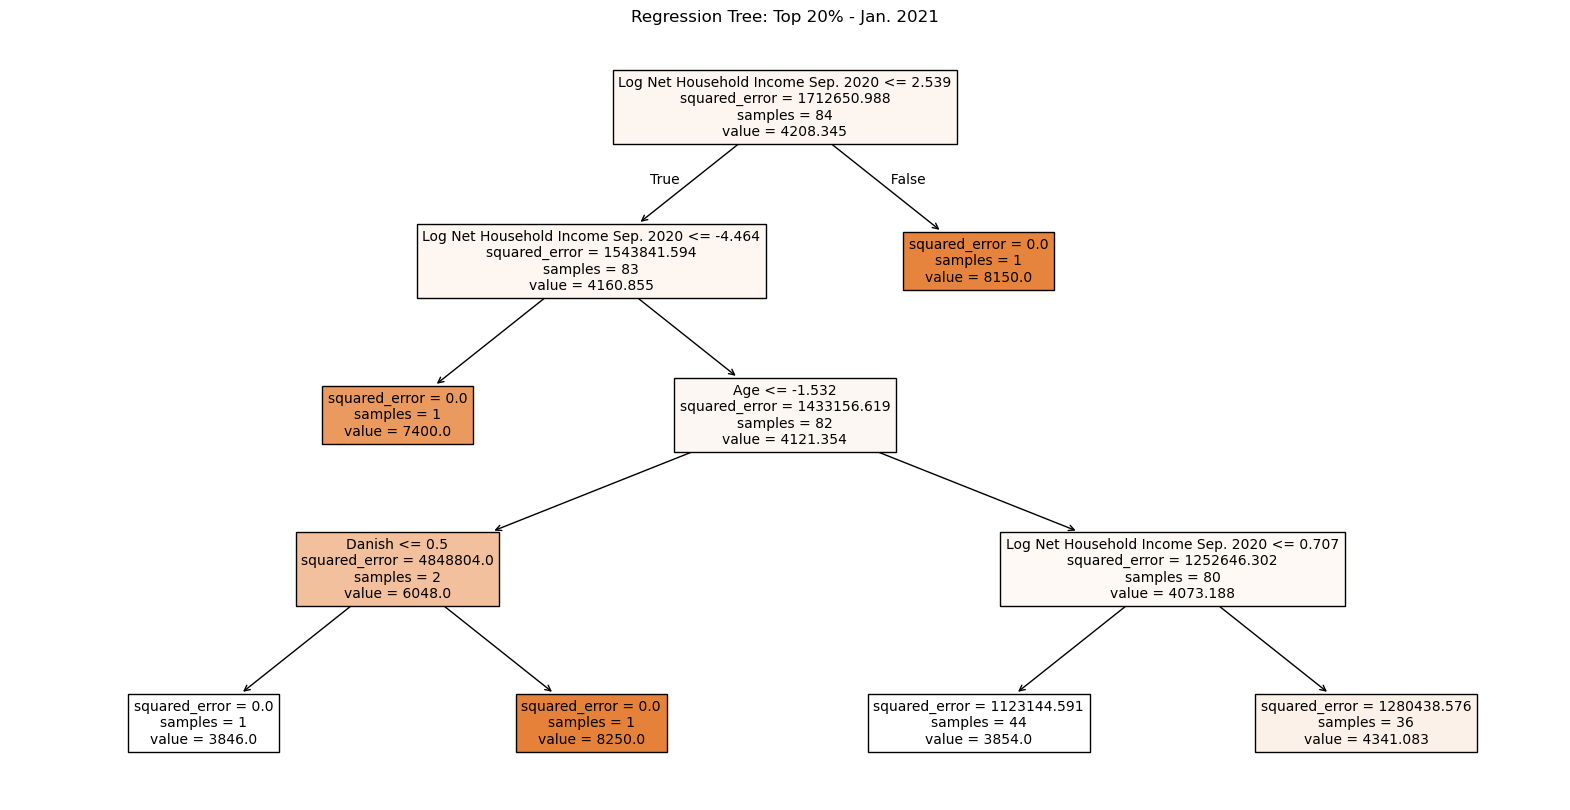

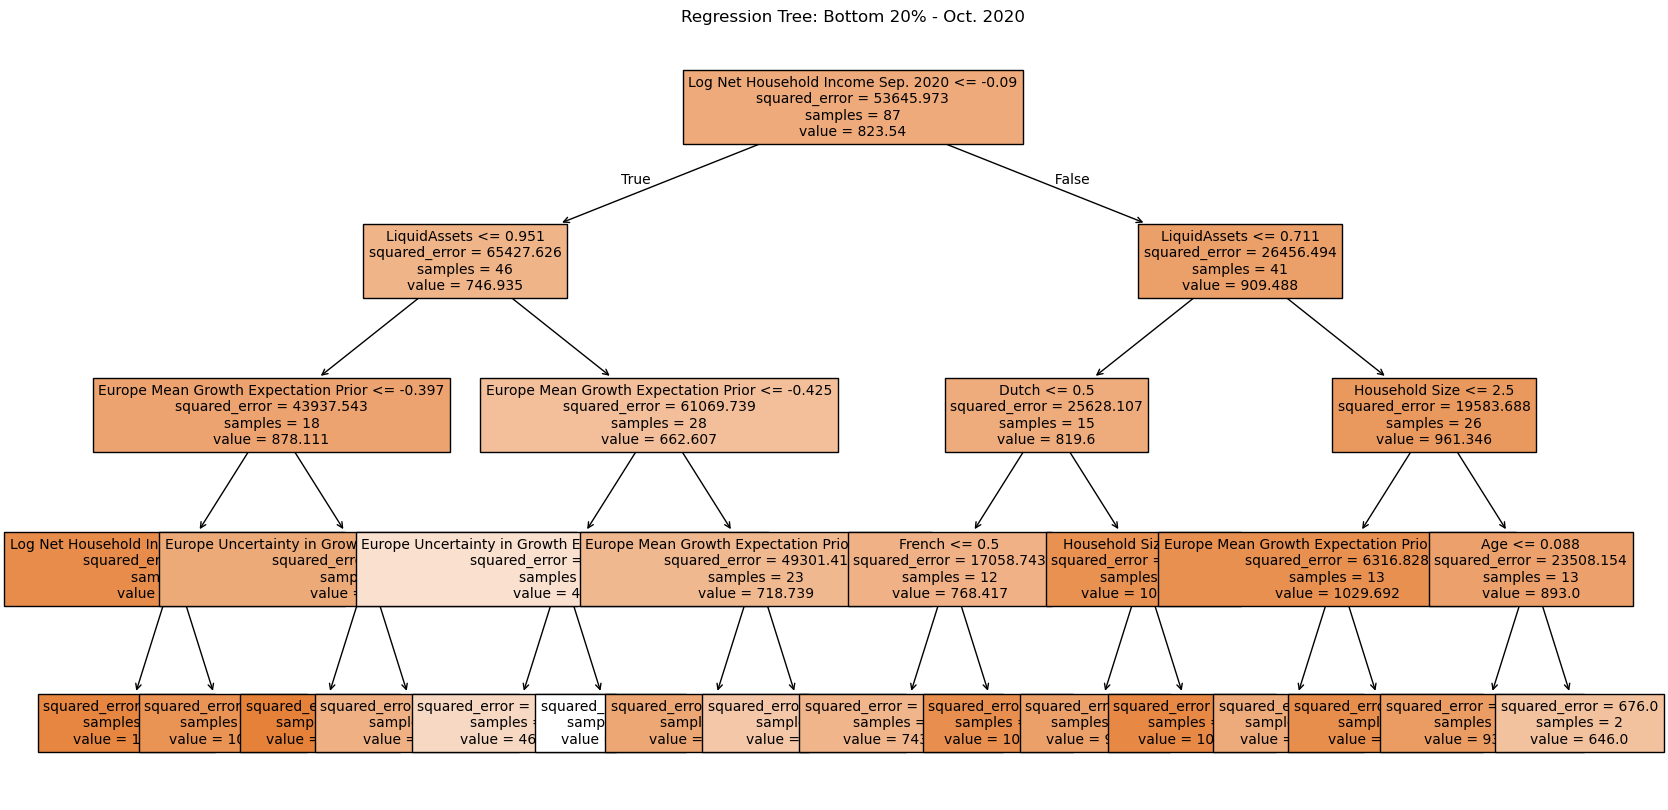

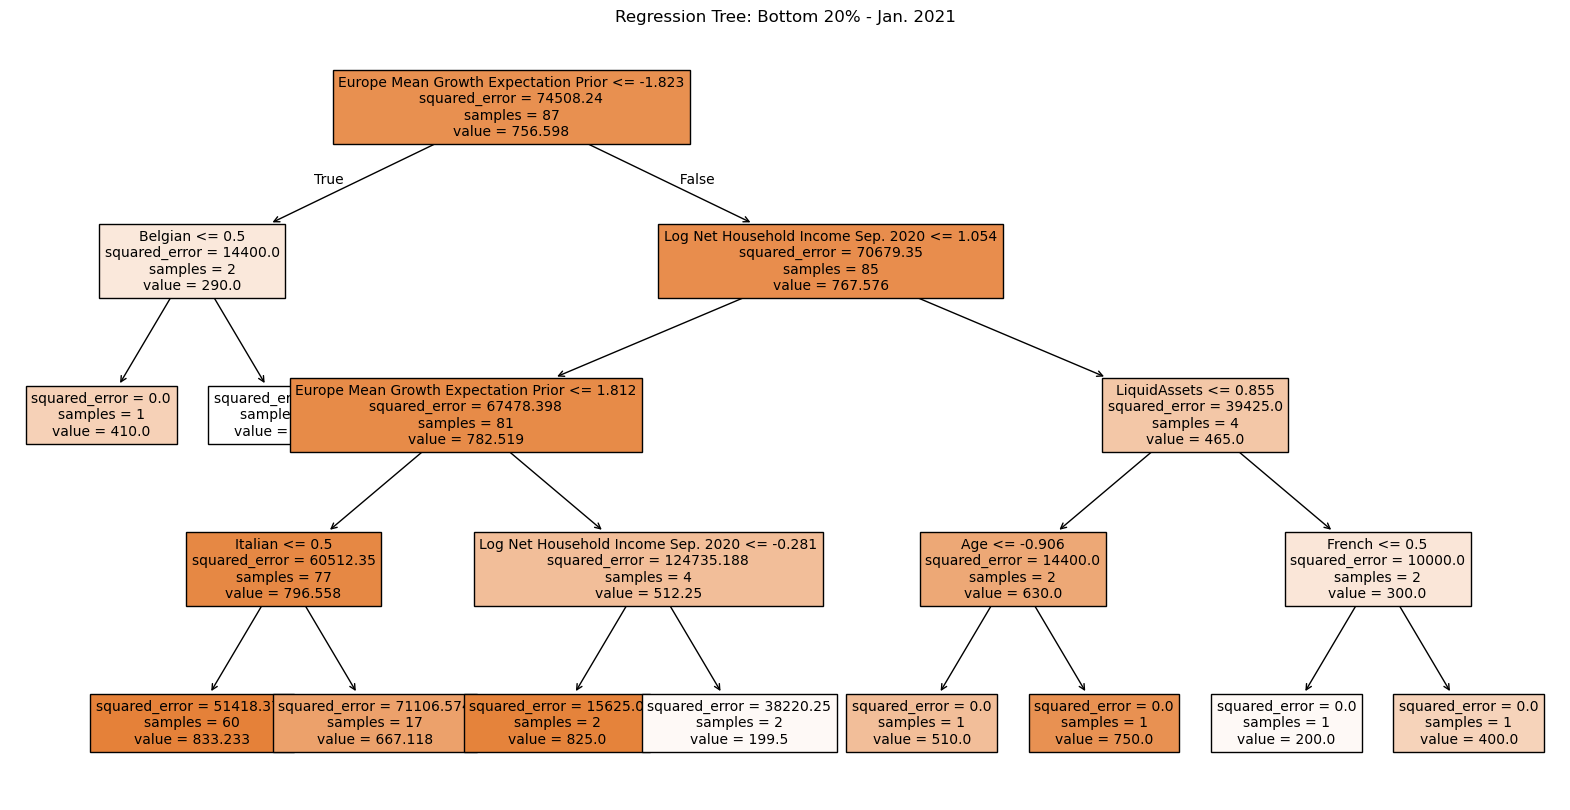

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Load the dataset
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Filter: only observations where Second Moment Europe Treatment == 1
df = df[df["Second Moment Europe Treatment"] == 1]

# Drop IlliquidAssets to avoid perfect multicollinearity
if "IlliquidAssets" in df.columns:
    df = df.drop(columns=["IlliquidAssets"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthly Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Compute top/bottom 20% masks
top_20_mask = (df_filtered["Total Monthly Consumption Oct. 2020"] >= np.percentile(df_filtered["Total Monthly Consumption Oct. 2020"], 80)) & \
              (df_filtered["Total Monthly Consumption Jan. 2021"] >= np.percentile(df_filtered["Total Monthly Consumption Jan. 2021"], 80))

bottom_20_mask = (df_filtered["Total Monthly Consumption Oct. 2020"] <= np.percentile(df_filtered["Total Monthly Consumption Oct. 2020"], 20)) & \
                 (df_filtered["Total Monthly Consumption Jan. 2021"] <= np.percentile(df_filtered["Total Monthly Consumption Jan. 2021"], 20))

# Function to run regression tree and plot
def run_regression_tree(df_masked, y_col, title):
    predictors = [col for col in df_masked.columns if col not in [
        "Total Monthly Consumption Oct. 2020",
        "Total Monthly Consumption Jan. 2021",
        "Control Group"
    ]]
    
    X = df_masked[predictors].astype(float)
    y = df_masked[y_col].astype(float)
    
    # Fit regression tree (no scaling)
    tree = DecisionTreeRegressor(max_depth=4, random_state=42)
    tree.fit(X, y)
    
    # Plot tree
    plt.figure(figsize=(20,10))
    plot_tree(tree, feature_names=X.columns, filled=True, fontsize=10)
    plt.title(title)
    plt.show()

# Run regression trees for top 20%
run_regression_tree(df_filtered[top_20_mask], "Total Monthly Consumption Oct. 2020", 
                    "Regression Tree: Top 20% - Oct. 2020")
run_regression_tree(df_filtered[top_20_mask], "Total Monthly Consumption Jan. 2021", 
                    "Regression Tree: Top 20% - Jan. 2021")

# Run regression trees for bottom 20%
run_regression_tree(df_filtered[bottom_20_mask], "Total Monthly Consumption Oct. 2020", 
                    "Regression Tree: Bottom 20% - Oct. 2020")
run_regression_tree(df_filtered[bottom_20_mask], "Total Monthly Consumption Jan. 2021", 
                    "Regression Tree: Bottom 20% - Jan. 2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\33766410.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\33766410.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.98864583e+0

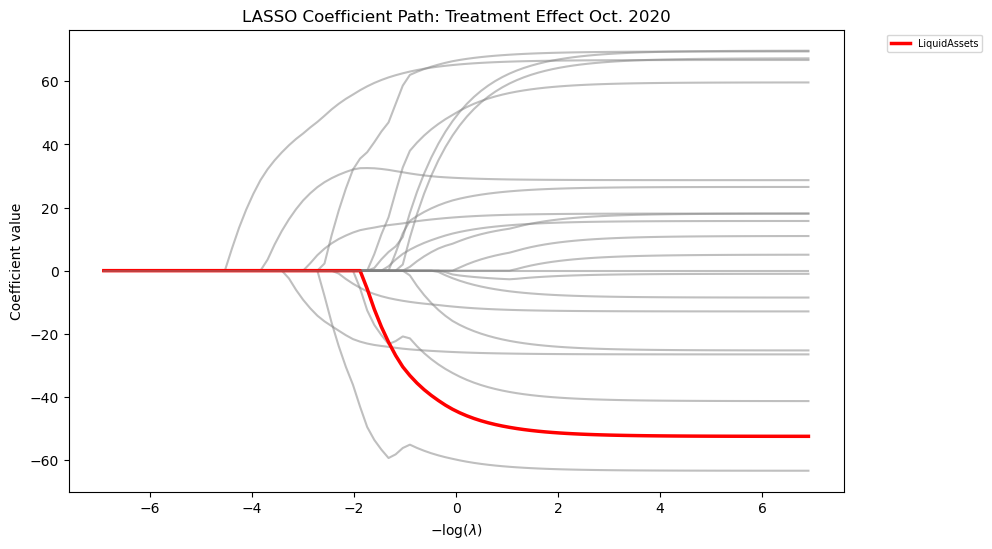

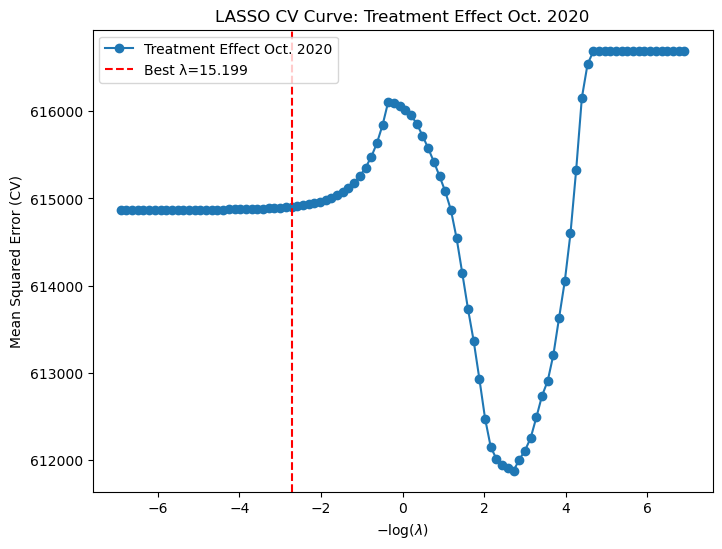

✅ Best LASSO alpha for Treatment Effect Oct. 2020: 15.1991


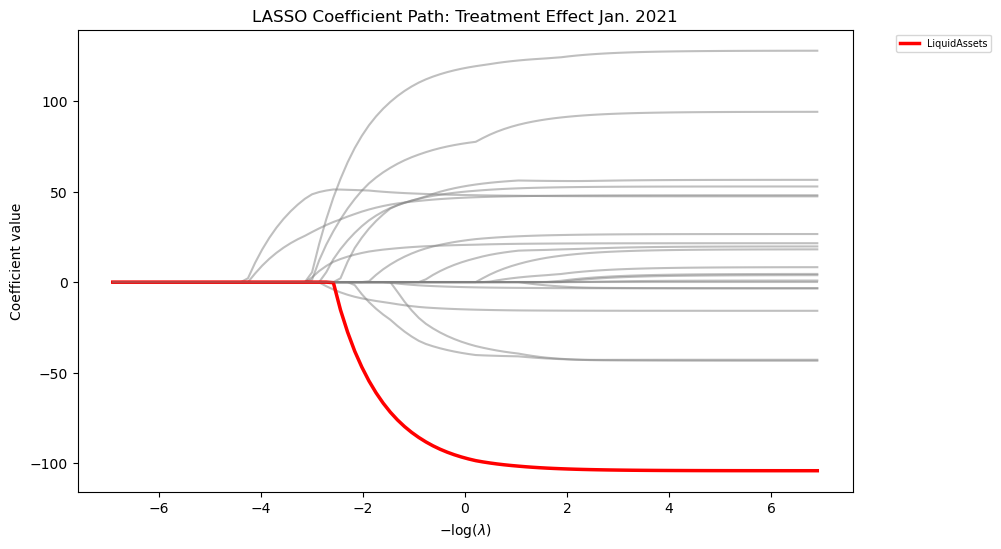

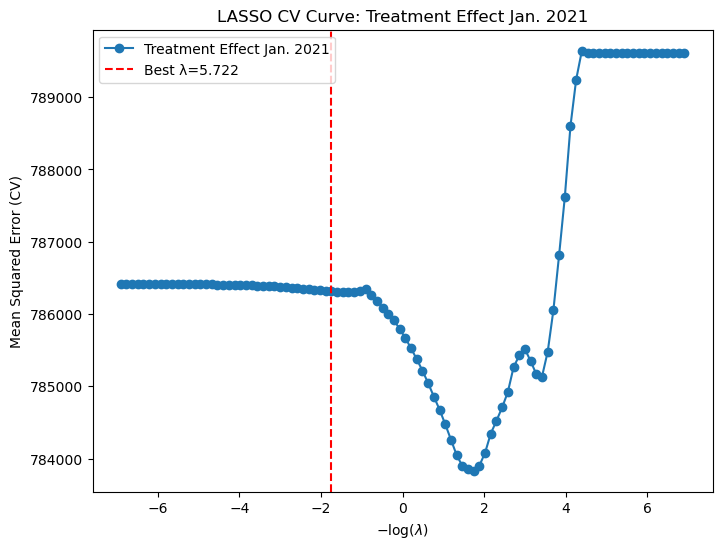

✅ Best LASSO alpha for Treatment Effect Jan. 2021: 5.7224


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]
predictors = [col for col in df.columns if col not in exclude_cols]

X = df[predictors].astype(float)

# LASSO settings
alphas = np.logspace(-3, 3, 100)

# --- Function to run LASSO and plot ---
def run_lasso_te(X, y, label):
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)
    
    highlight_vars = {"LiquidAssets": "red"}
    
    plt.figure(figsize=(10,6))
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(-np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(-np.log(alphas), coefs[:, i], color="gray", alpha=0.5)
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Coefficient value")
    plt.title(f"LASSO Coefficient Path: {label}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="x-small")
    plt.show()
    
    # Cross-validation
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)
    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=label)
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Mean Squared Error (CV)")
    plt.title(f"LASSO CV Curve: {label}")
    plt.legend()
    plt.show()
    
    print(f"✅ Best LASSO alpha for {label}: {lassocv.alpha_:.4f}")

# --- Run LASSO for treatment effects ---
y_oct_te = df["TreatmentEffect_Oct"].astype(float)
y_jan_te = df["TreatmentEffect_Jan"].astype(float)

run_lasso_te(X, y_oct_te, "Treatment Effect Oct. 2020")
run_lasso_te(X, y_jan_te, "Treatment Effect Jan. 2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2421124699.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2421124699.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

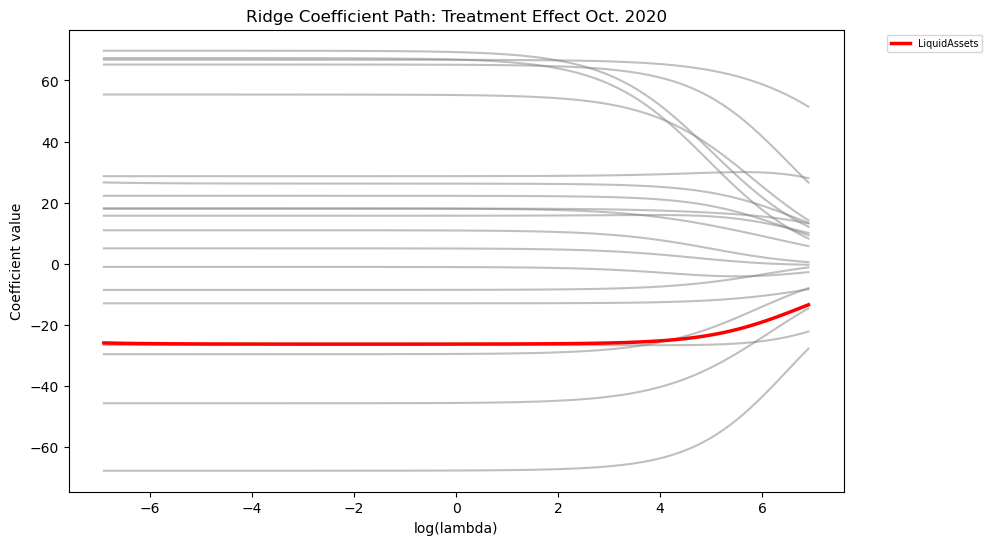

✅ Best Ridge alpha for Treatment Effect Oct. 2020: 1000.0000


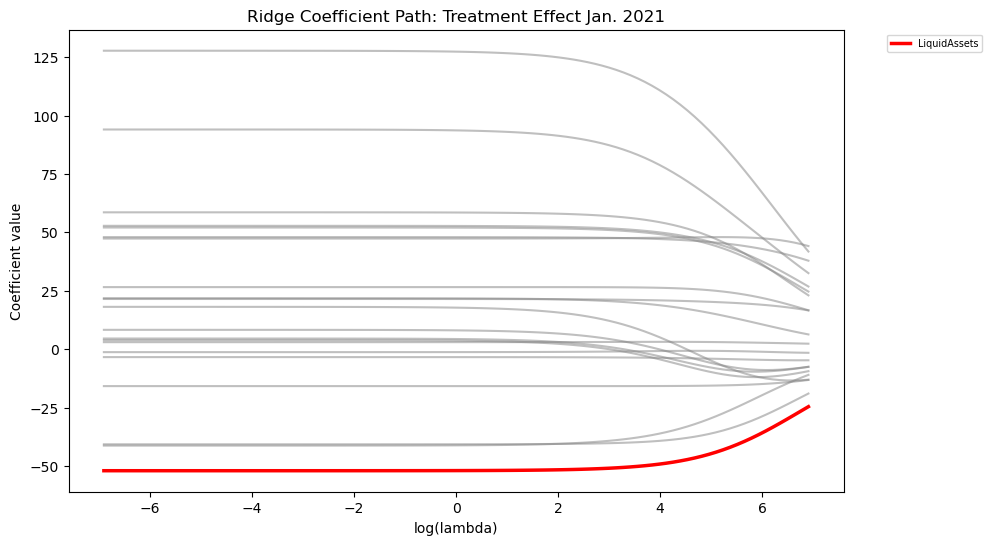

✅ Best Ridge alpha for Treatment Effect Jan. 2021: 1000.0000


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]
predictors = [col for col in df.columns if col not in exclude_cols]

X = df[predictors].astype(float)

# Ridge settings
alphas = np.logspace(-3, 3, 100)

# --- Function to run Ridge and plot ---
def run_ridge_te(X, y, label):
    # RidgeCV to find best alpha
    ridgecv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridgecv.fit(X, y)
    
    # Coefficient paths
    coefs = []
    for a in alphas:
        ridge = Ridge(alpha=a)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
    coefs = np.array(coefs)
    
    highlight_vars = {"LiquidAssets": "red"}
    
    plt.figure(figsize=(10,6))
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(np.log(alphas), coefs[:, i], color="gray", alpha=0.5)
    plt.xlabel("log(lambda)")
    plt.ylabel("Coefficient value")
    plt.title(f"Ridge Coefficient Path: {label}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="x-small")
    plt.show()
    
    print(f"✅ Best Ridge alpha for {label}: {ridgecv.alpha_:.4f}")

# --- Run Ridge for treatment effects ---
y_oct_te = df["TreatmentEffect_Oct"].astype(float)
y_jan_te = df["TreatmentEffect_Jan"].astype(float)

run_ridge_te(X, y_oct_te, "Treatment Effect Oct. 2020")
run_ridge_te(X, y_jan_te, "Treatment Effect Jan. 2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1570105781.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1570105781.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

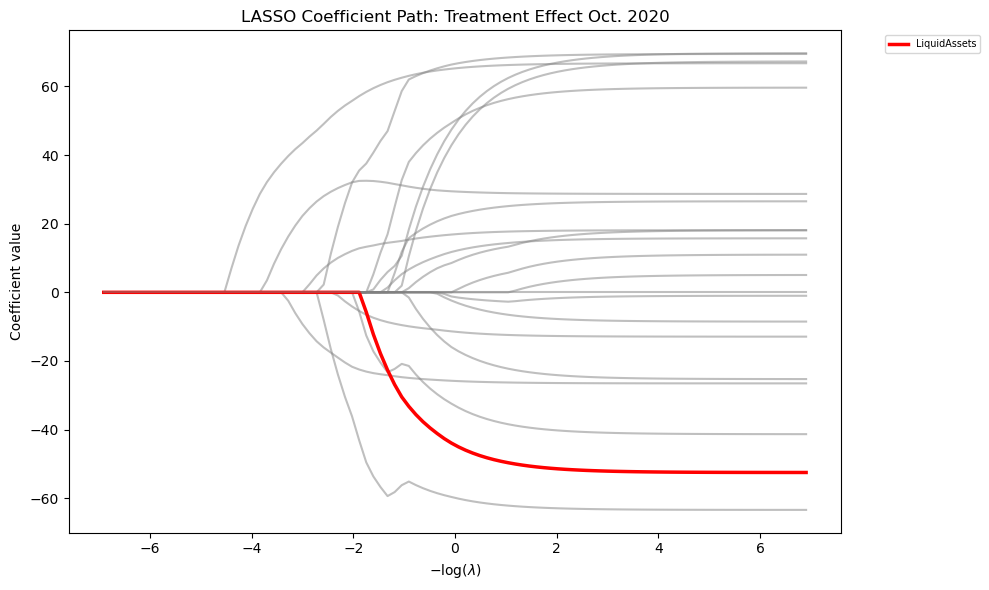

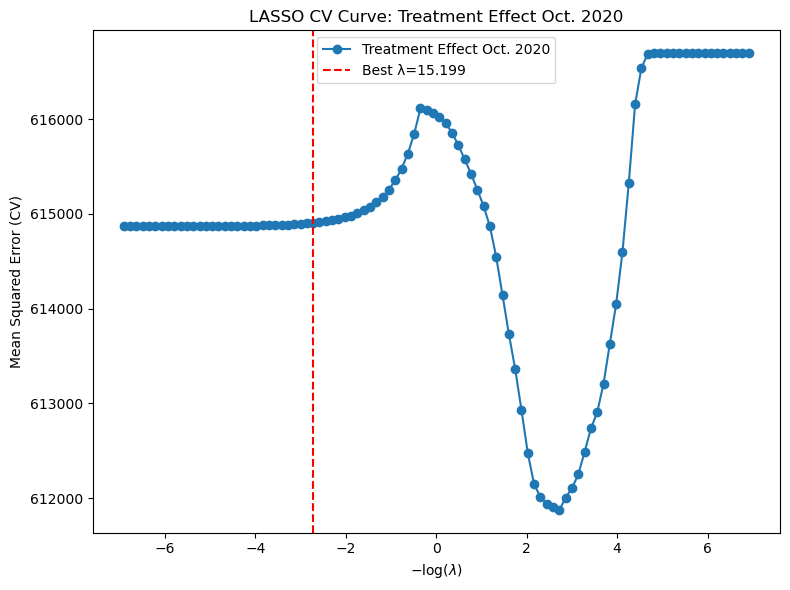

✅ Saved: Oct2020_CoeffPath.pdf and Oct2020_CVCurve.pdf
Best LASSO alpha for Treatment Effect Oct. 2020: 15.1991


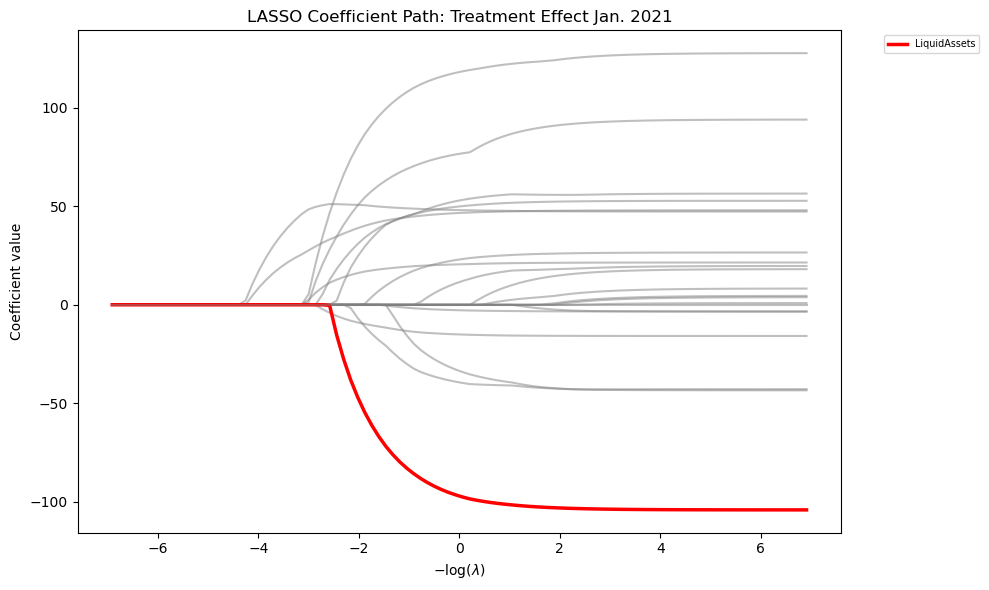

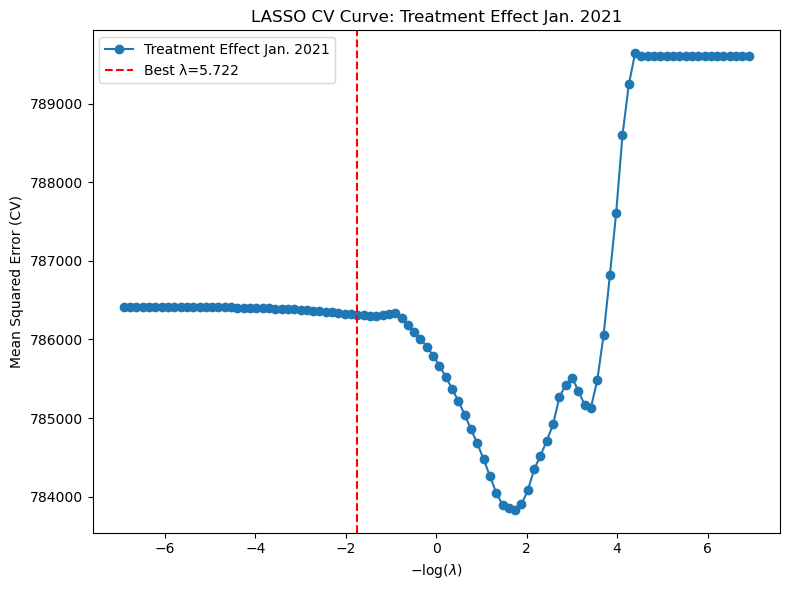

✅ Saved: Jan2021_CoeffPath.pdf and Jan2021_CVCurve.pdf
Best LASSO alpha for Treatment Effect Jan. 2021: 5.7224


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]
predictors = [col for col in df.columns if col not in exclude_cols]

X = df[predictors].astype(float)

# LASSO settings
alphas = np.logspace(-3, 3, 100)

# --- Function to run LASSO, plot, and save PDF ---
def run_lasso_save(X, y, label, prefix):
    # Coefficient path
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)
    
    plt.figure(figsize=(10,6))
    highlight_vars = {"LiquidAssets": "red"}
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(-np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(-np.log(alphas), coefs[:, i], color="gray", alpha=0.5)
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Coefficient value")
    plt.title(f"LASSO Coefficient Path: {label}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{prefix}_CoeffPath.pdf")   # Save as PDF
    plt.show()
    plt.close()
    
    # Cross-validation curve
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)
    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=label)
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Mean Squared Error (CV)")
    plt.title(f"LASSO CV Curve: {label}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{prefix}_CVCurve.pdf")   # Save as PDF
    plt.show()
    plt.close()
    
    print(f"✅ Saved: {prefix}_CoeffPath.pdf and {prefix}_CVCurve.pdf")
    print(f"Best LASSO alpha for {label}: {lassocv.alpha_:.4f}")

# --- Run for both treatment effects ---
y_oct_te = df["TreatmentEffect_Oct"].astype(float)
y_jan_te = df["TreatmentEffect_Jan"].astype(float)

run_lasso_save(X, y_oct_te, "Treatment Effect Oct. 2020", "Oct2020")
run_lasso_save(X, y_jan_te, "Treatment Effect Jan. 2021", "Jan2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1608709519.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1608709519.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

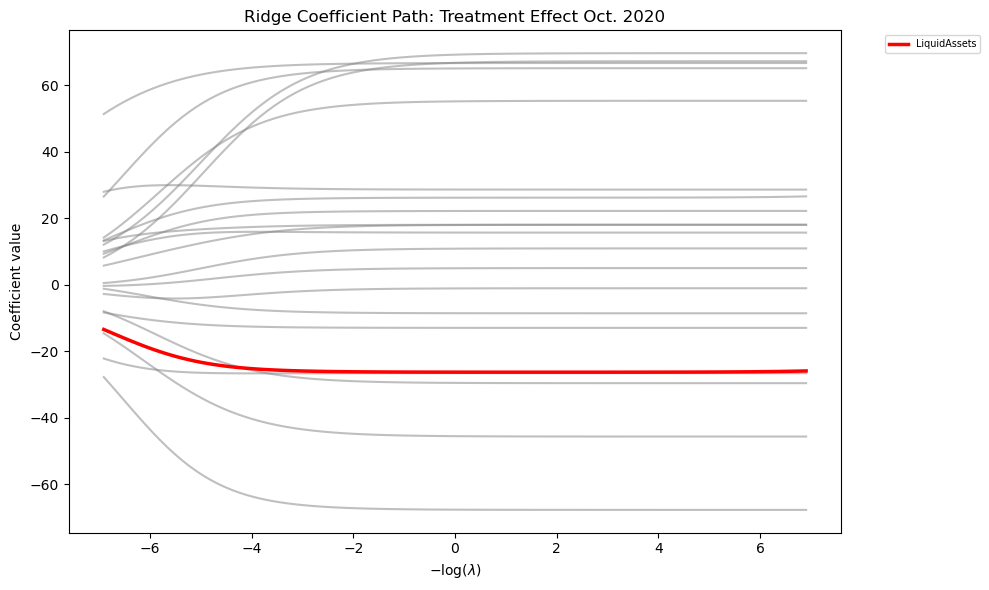

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

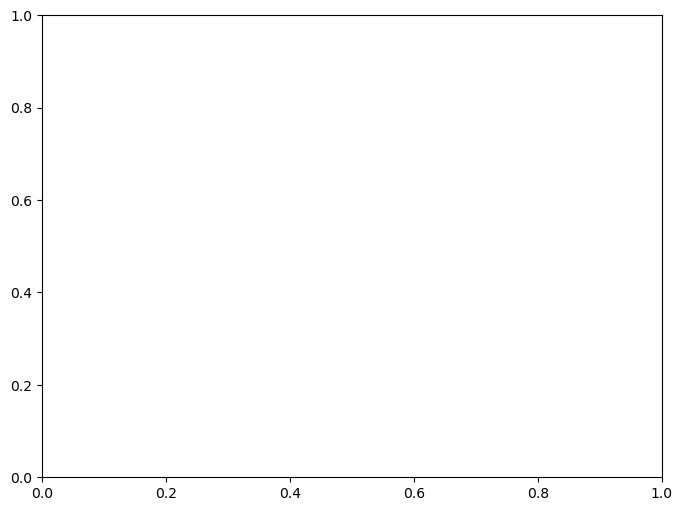

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]
predictors = [col for col in df.columns if col not in exclude_cols]

X = df[predictors].astype(float)

# Ridge settings
alphas = np.logspace(-3, 3, 100)

# --- Function to run Ridge, plot, and save PDF ---
def run_ridge_save(X, y, label, prefix):
    # Ridge coefficient paths
    coefs = []
    for a in alphas:
        ridge = Ridge(alpha=a, max_iter=10000)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
    coefs = np.array(coefs)
    
    plt.figure(figsize=(10,6))
    highlight_vars = {"LiquidAssets": "red"}
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(-np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(-np.log(alphas), coefs[:, i], color="gray", alpha=0.5)
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Coefficient value")
    plt.title(f"Ridge Coefficient Path: {label}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{prefix}_Ridge_CoeffPath.pdf")
    plt.show()
    plt.close()
    
    # RidgeCV for cross-validation
    ridgecv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridgecv.fit(X, y)
    
    mse_mean = np.mean([np.mean((y - Ridge(alpha=a).fit(X, y).predict(X))**2) for a in alphas], axis=0)
    
    plt.figure(figsize=(8,6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=label)
    plt.axvline(-np.log(ridgecv.alpha_), linestyle="--", color="red", label=f"Best λ={ridgecv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Mean Squared Error (CV)")
    plt.title(f"Ridge CV Curve: {label}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{prefix}_Ridge_CVCurve.pdf")
    plt.show()
    plt.close()
    
    print(f"✅ Saved: {prefix}_Ridge_CoeffPath.pdf and {prefix}_Ridge_CVCurve.pdf")
    print(f"Best Ridge alpha for {label}: {ridgecv.alpha_:.4f}")

# --- Run for both treatment effects ---
y_oct_te = df["TreatmentEffect_Oct"].astype(float)
y_jan_te = df["TreatmentEffect_Jan"].astype(float)

run_ridge_save(X, y_oct_te, "Treatment Effect Oct. 2020", "Oct2020")
run_ridge_save(X, y_jan_te, "Treatment Effect Jan. 2021", "Jan2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2321483083.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2321483083.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

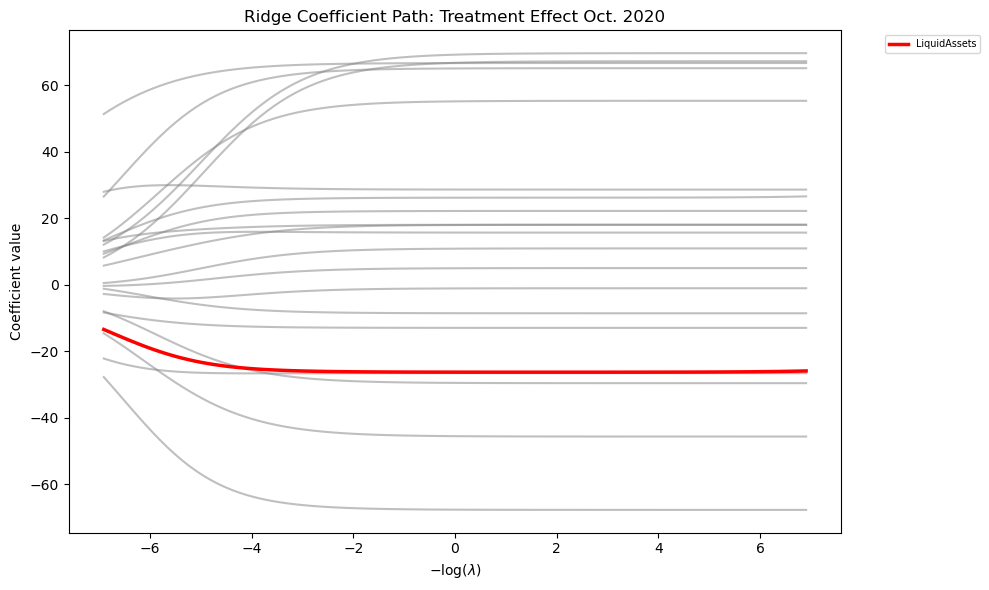

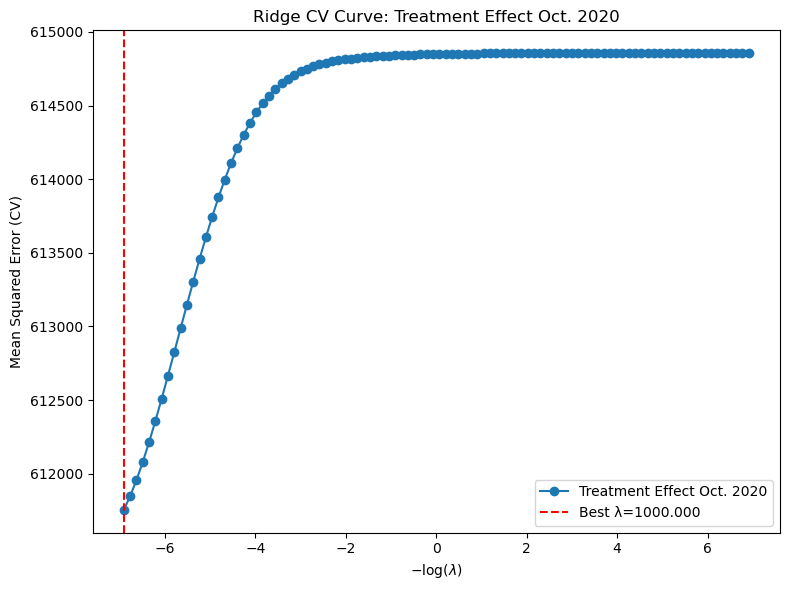

✅ Saved: Oct2020_Ridge_CoeffPath.pdf and Oct2020_Ridge_CVCurve.pdf
Best Ridge alpha for Treatment Effect Oct. 2020: 1000.0000


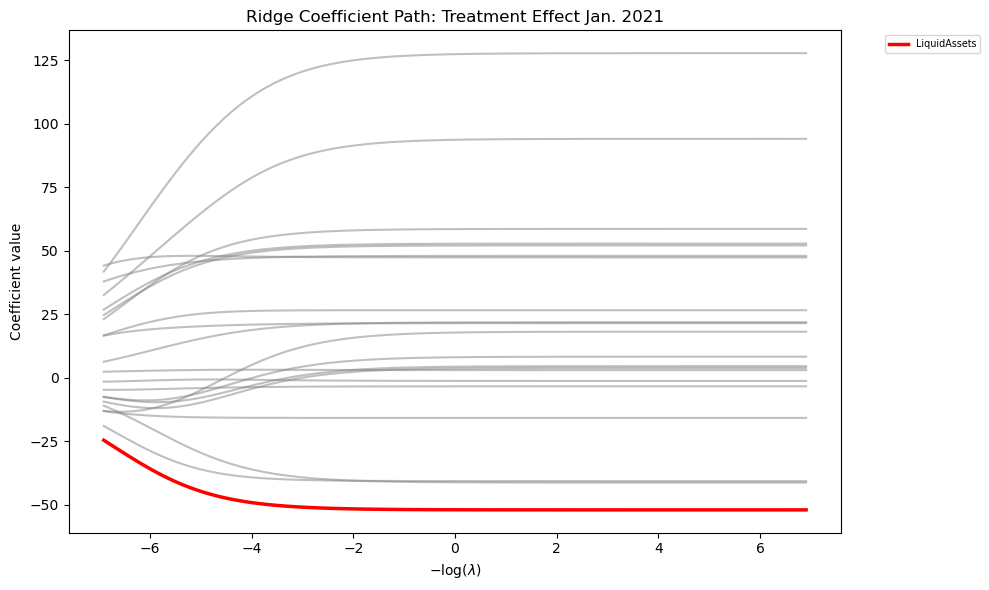

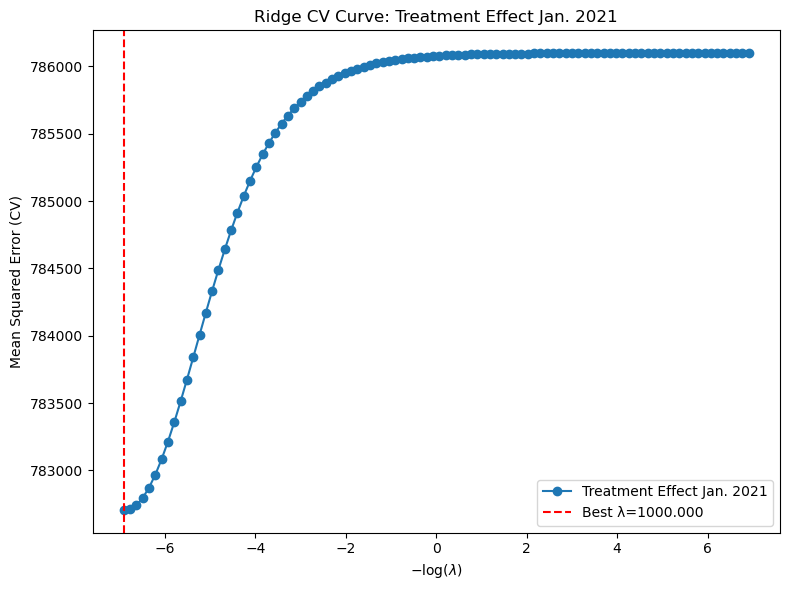

✅ Saved: Jan2021_Ridge_CoeffPath.pdf and Jan2021_Ridge_CVCurve.pdf
Best Ridge alpha for Treatment Effect Jan. 2021: 1000.0000


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]
predictors = [col for col in df.columns if col not in exclude_cols]

X = df[predictors].astype(float)

# Ridge settings
alphas = np.logspace(-3, 3, 100)

# --- Ridge plotting and saving function ---
def run_ridge_save(X, y, label, prefix):
    # Coefficient path
    coefs = []
    for a in alphas:
        ridge = Ridge(alpha=a, max_iter=10000)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
    coefs = np.array(coefs)
    
    plt.figure(figsize=(10,6))
    highlight_vars = {"LiquidAssets": "red"}
    for i, col in enumerate(X.columns):
        if col in highlight_vars:
            plt.plot(-np.log(alphas), coefs[:, i], label=col, color=highlight_vars[col], linewidth=2.5)
        else:
            plt.plot(-np.log(alphas), coefs[:, i], color="gray", alpha=0.5)
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Coefficient value")
    plt.title(f"Ridge Coefficient Path: {label}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{prefix}_Ridge_CoeffPath.pdf")
    plt.show()
    plt.close()
    
    # RidgeCV for best alpha
    ridgecv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridgecv.fit(X, y)
    
    # Compute CV MSE for all alphas
    mse_mean = []
    for a in alphas:
        ridge = Ridge(alpha=a, max_iter=10000)
        scores = cross_val_score(ridge, X, y, cv=5, scoring=make_scorer(mean_squared_error))
        mse_mean.append(scores.mean())
    mse_mean = np.array(mse_mean)
    
    plt.figure(figsize=(8,6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=label)
    plt.axvline(-np.log(ridgecv.alpha_), linestyle="--", color="red", label=f"Best λ={ridgecv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Mean Squared Error (CV)")
    plt.title(f"Ridge CV Curve: {label}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{prefix}_Ridge_CVCurve.pdf")
    plt.show()
    plt.close()
    
    print(f"✅ Saved: {prefix}_Ridge_CoeffPath.pdf and {prefix}_Ridge_CVCurve.pdf")
    print(f"Best Ridge alpha for {label}: {ridgecv.alpha_:.4f}")

# --- Run for both treatment effects ---
y_oct_te = df["TreatmentEffect_Oct"].astype(float)
y_jan_te = df["TreatmentEffect_Jan"].astype(float)

run_ridge_save(X, y_oct_te, "Treatment Effect Oct. 2020", "Oct2020")
run_ridge_save(X, y_jan_te, "Treatment Effect Jan. 2021", "Jan2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3453648605.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3453648605.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

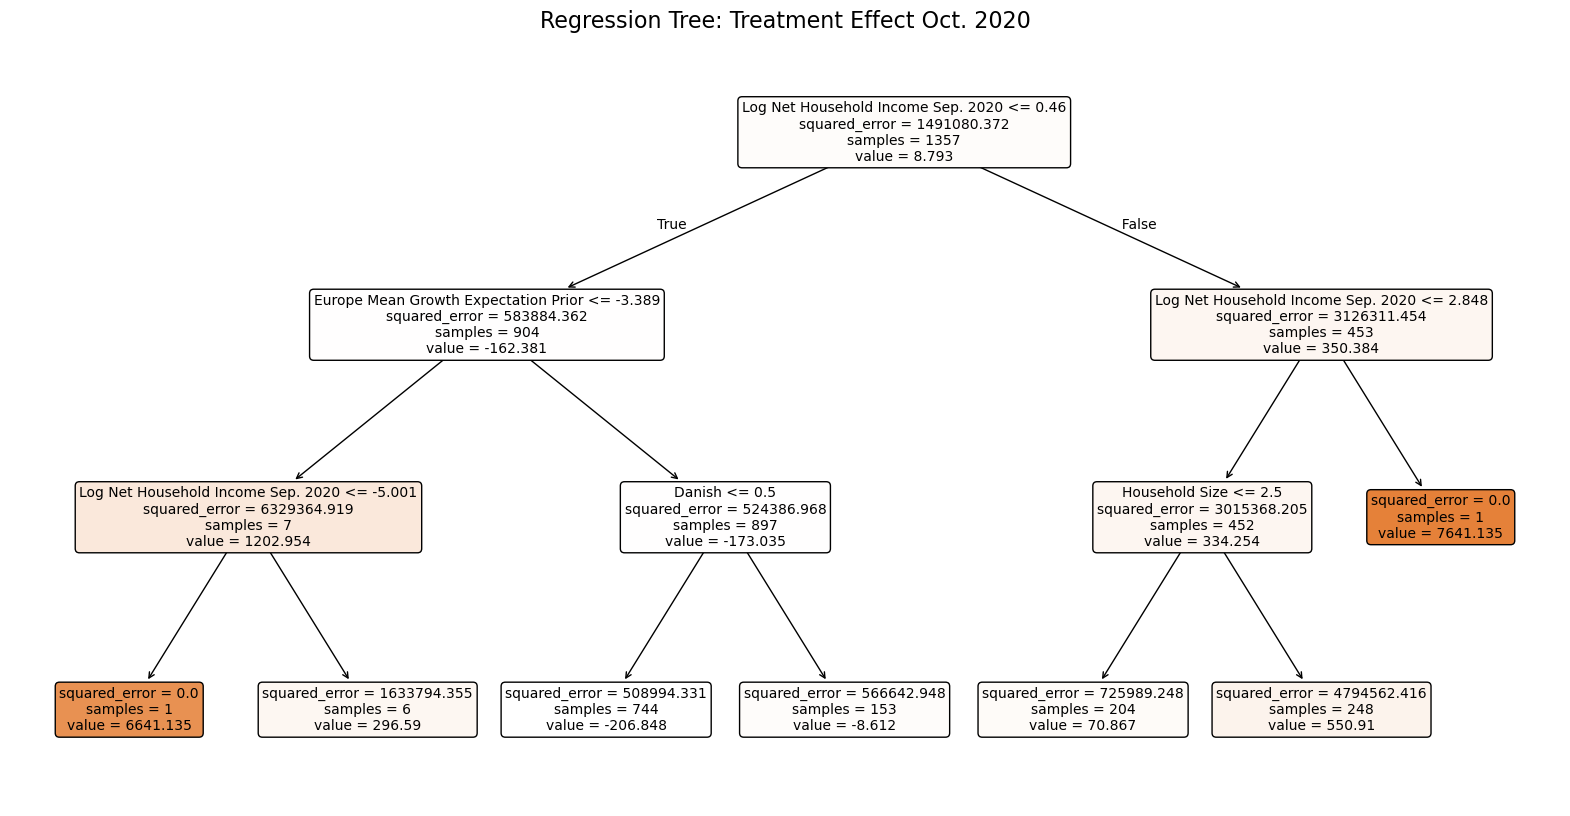

✅ Displayed regression tree for Treatment Effect Oct. 2020


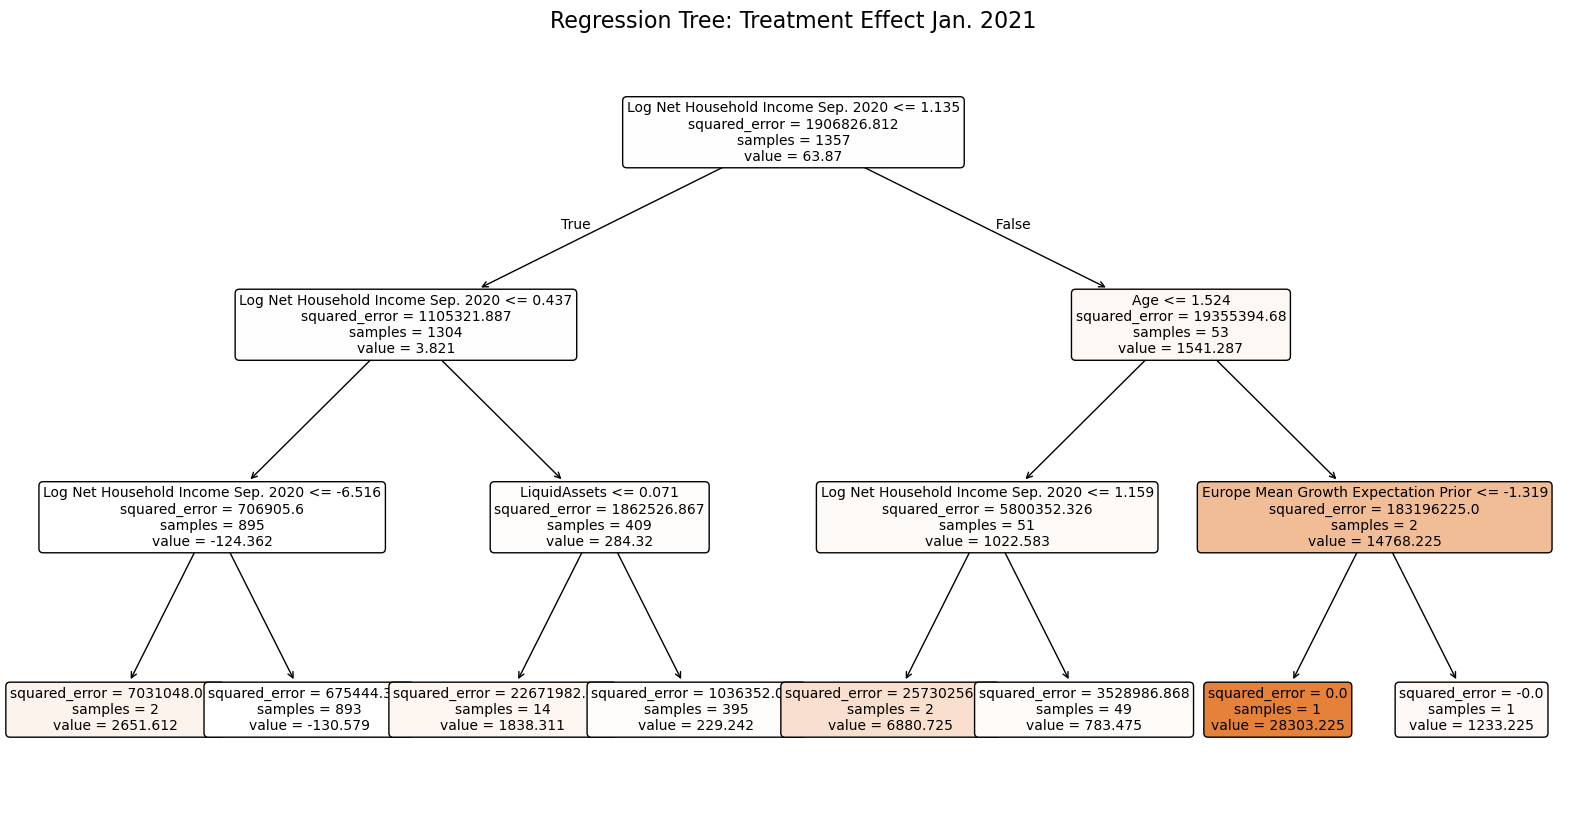

✅ Displayed regression tree for Treatment Effect Jan. 2021


In [31]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Filter for Control + Europe Treatment group ---
df_tree = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)]

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Second Moment Europe Treatment",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]

predictors = [col for col in df_tree.columns if col not in exclude_cols]

X = df_tree[predictors].astype(float)

# --- Regression tree function ---
def run_regression_tree(y, label, max_depth=3):
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree.fit(X, y)
    
    plt.figure(figsize=(20,10))
    plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
    plt.title(f"Regression Tree: {label}", fontsize=16)
    plt.show()
    
    print(f"✅ Displayed regression tree for {label}")

# --- Run trees for both treatment effects ---
y_oct_te = df_tree["TreatmentEffect_Oct"].astype(float)
y_jan_te = df_tree["TreatmentEffect_Jan"].astype(float)

run_regression_tree(y_oct_te, "Treatment Effect Oct. 2020")
run_regression_tree(y_jan_te, "Treatment Effect Jan. 2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3961458397.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3961458397.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458


Feature Importance for Treatment Effect Oct. 2020 (sorted):
Log Net Household Income Sep. 2020                0.458063
Europe Mean Growth Expectation Prior              0.149444
Europe Uncertainty in Growth Expectation Prior    0.058386
Household Size                                    0.058049
IlliquidAssets                                    0.053345
Age                                               0.052477
LiquidAssets                                      0.052234
High-School Educated                              0.028283
Dutch                                             0.026426
Male                                              0.022656
Post-Secondary Educated                           0.014816
Danish                                            0.010283
Italian                                           0.008105
French                                            0.002882
Sufficient Liquidity                              0.002408
Spanish                                           0.00

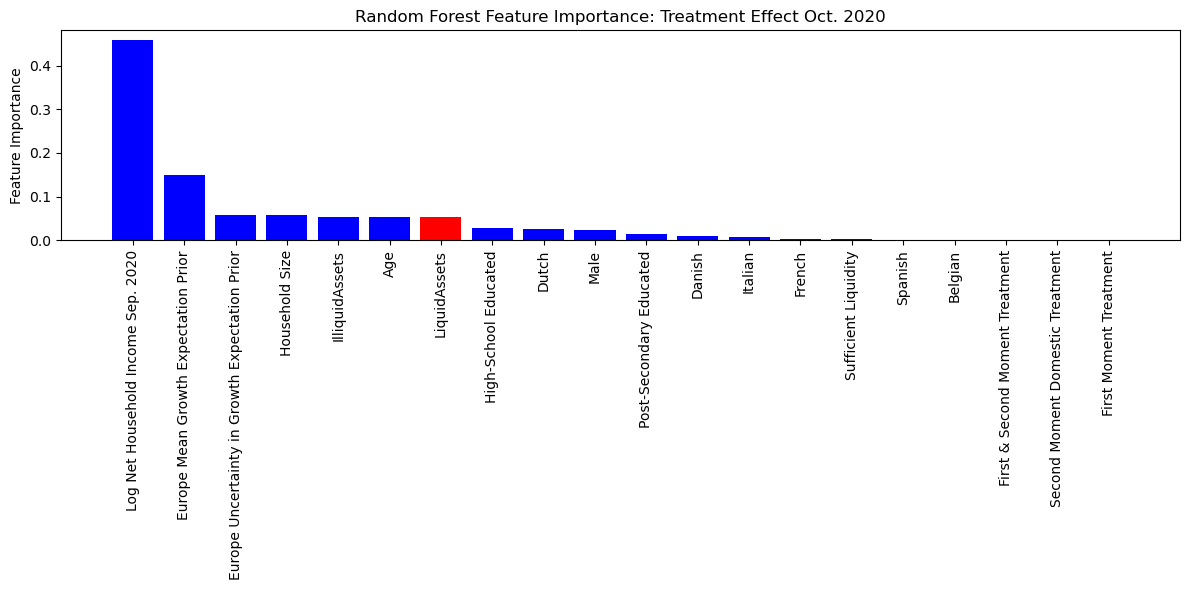


Feature Importance for Treatment Effect Jan. 2021 (sorted):
Log Net Household Income Sep. 2020                0.282590
Age                                               0.226186
Europe Mean Growth Expectation Prior              0.163368
LiquidAssets                                      0.116186
IlliquidAssets                                    0.060021
Household Size                                    0.040746
Italian                                           0.032083
Europe Uncertainty in Growth Expectation Prior    0.029840
Dutch                                             0.008614
Post-Secondary Educated                           0.007911
Belgian                                           0.007506
Sufficient Liquidity                              0.006690
High-School Educated                              0.006347
Male                                              0.005968
Danish                                            0.002998
French                                            0.00

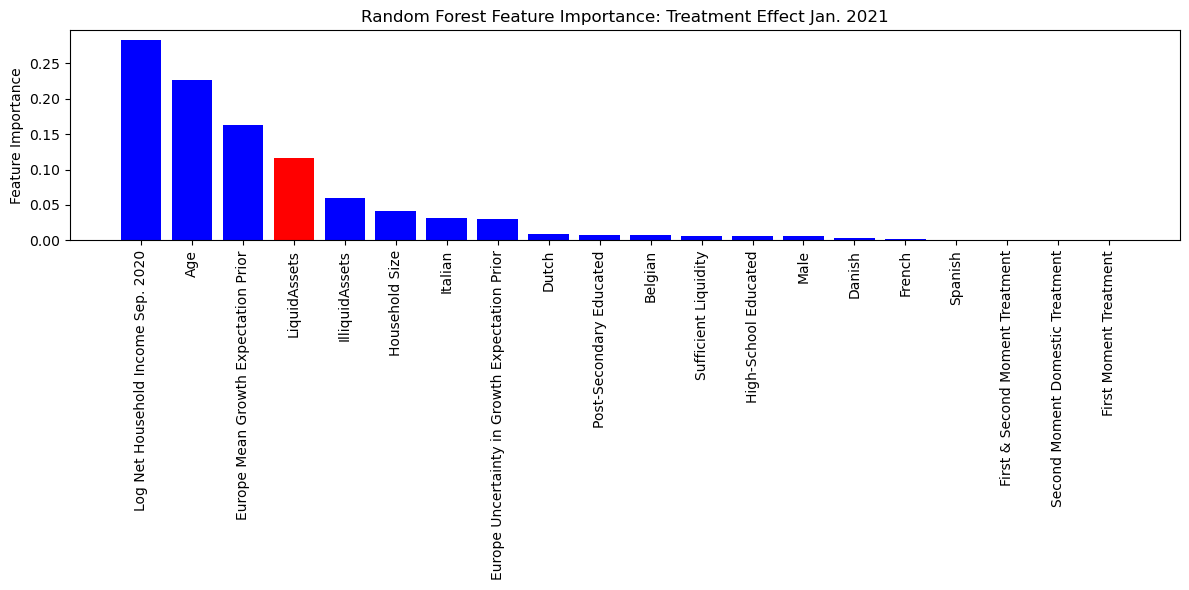

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Filter for Control + Europe Treatment group ---
df_rf = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)]

# --- Prepare predictors ---
exclude_cols = ["Control Group",
                "Second Moment Europe Treatment",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021",
                "TreatmentEffect_Oct",
                "TreatmentEffect_Jan"]

predictors = [col for col in df_rf.columns if col not in exclude_cols]
X = df_rf[predictors].astype(float)

# --- Random Forest function ---
def run_rf_importance(y, label, n_estimators=500, max_depth=4):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X, y)
    
    # Feature importances
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)
    
    # Display importance matrix
    print(f"\nFeature Importance for {label} (sorted):")
    print(importances)
    
    # Plot bar chart
    plt.figure(figsize=(12,6))
    colors = ["red" if i=="LiquidAssets" else "blue" for i in importances.index]
    plt.bar(importances.index, importances.values, color=colors)
    plt.xticks(rotation=90)
    plt.ylabel("Feature Importance")
    plt.title(f"Random Forest Feature Importance: {label}")
    plt.tight_layout()
    plt.show()
    
# --- Run for both treatment effects ---
y_oct_te = df_rf["TreatmentEffect_Oct"].astype(float)
y_jan_te = df_rf["TreatmentEffect_Jan"].astype(float)

run_rf_importance(y_oct_te, "Treatment Effect Oct. 2020")
run_rf_importance(y_jan_te, "Treatment Effect Jan. 2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2222018198.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e+03, tolerance: 1.352e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.553e+03, tolerance: 1.352e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\skl

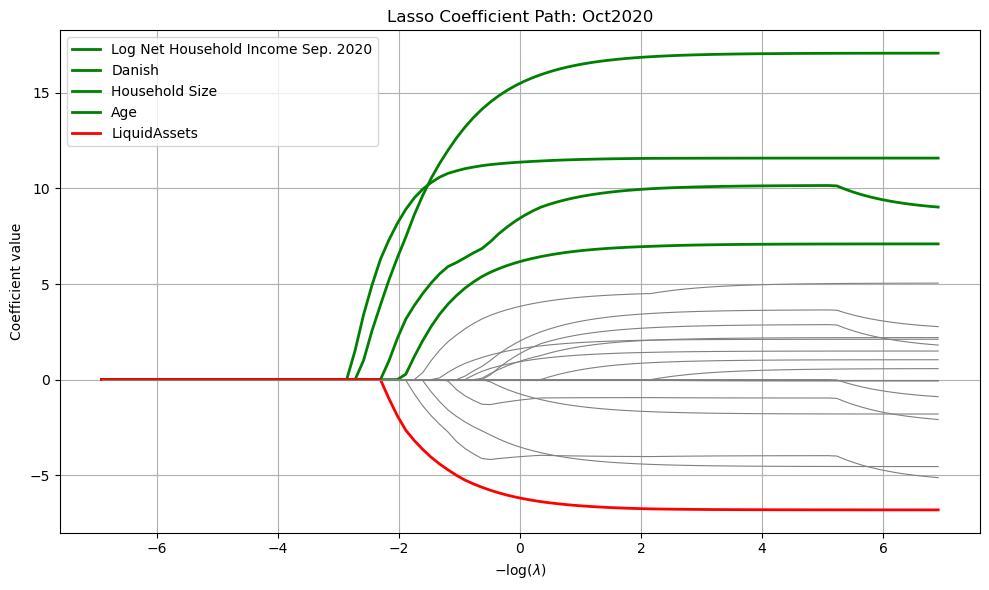

✅ Saved Oct2020_Lasso_CoeffPath.pdf


C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e+03, tolerance: 1.457e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e+03, tolerance: 1.457e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+03, tolerance: 

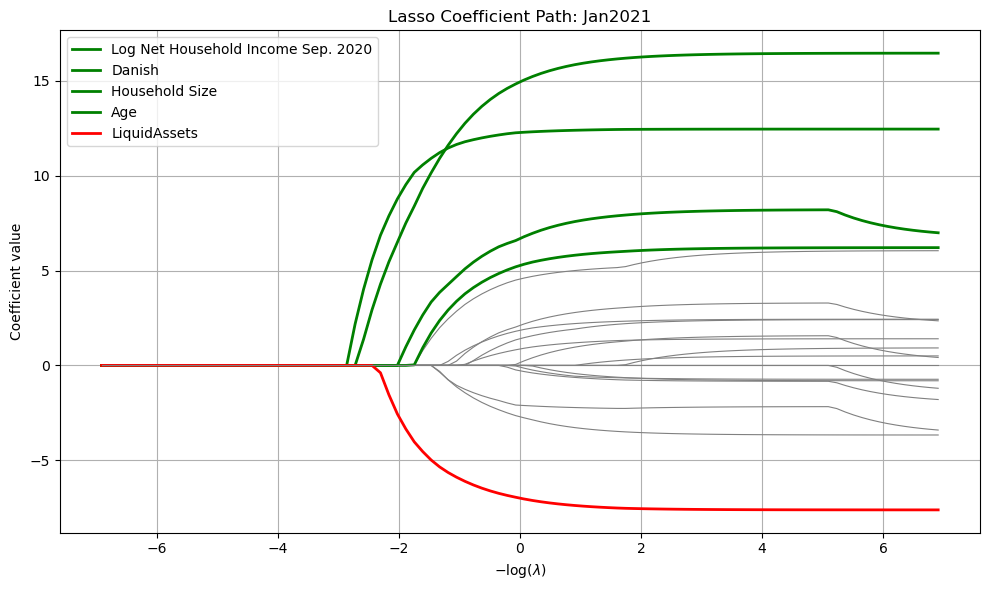

✅ Saved Jan2021_Lasso_CoeffPath.pdf


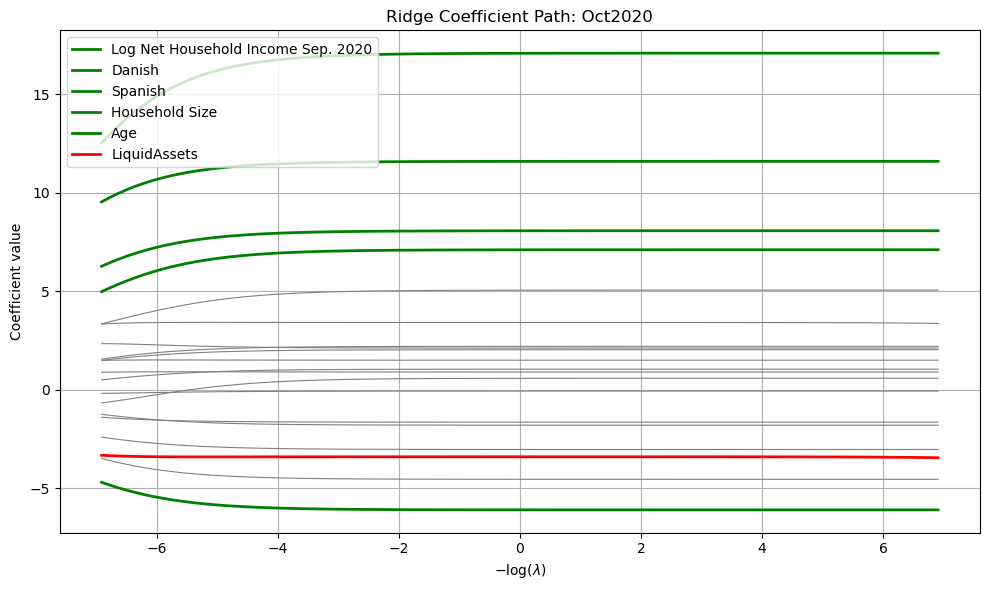

✅ Saved Oct2020_Ridge_CoeffPath.pdf


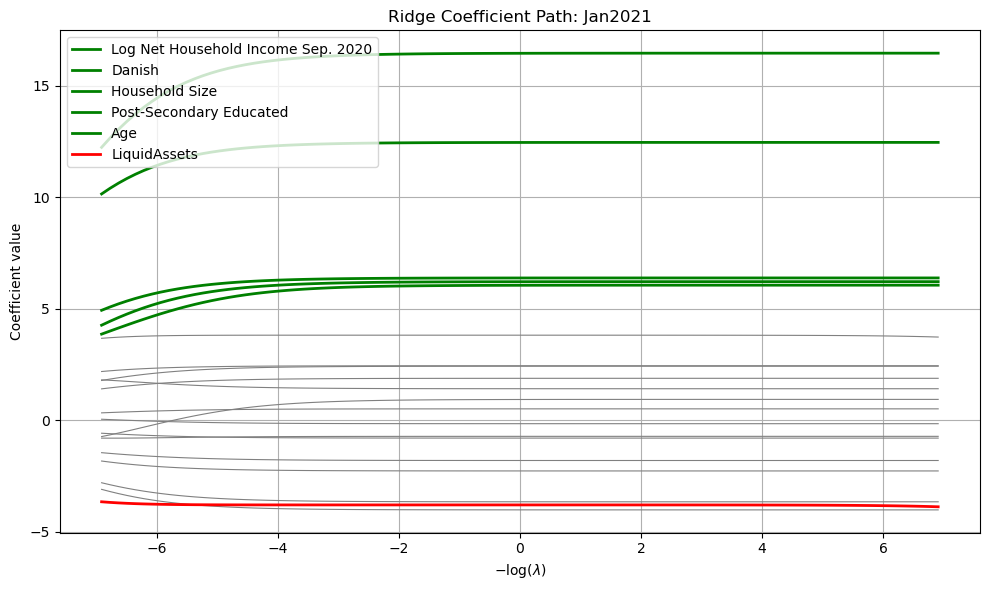

✅ Saved Jan2021_Ridge_CoeffPath.pdf


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Define predictors ---
exclude_cols = ["Control Group",
                "Second Moment Europe Treatment",
                "Total Monthly Consumption Oct. 2020",
                "Total Monthly Consumption Jan. 2021"]

predictors = [col for col in df.columns if col not in exclude_cols]
X = df[predictors].astype(float)

# --- Standardize predictors ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Define outcomes ---
y_oct = 100 * np.log(df["Total Monthly Consumption Oct. 2020"].astype(float))
y_jan = 100 * np.log(df["Total Monthly Consumption Jan. 2021"].astype(float))

# --- Regularization path function (highlight strongest predictors) ---
def plot_reg_path(X, y, model_type="lasso", label="Oct2020", filename="coeff_path.pdf"):
    alphas = np.logspace(-3, 3, 100)
    coefs = []

    # Compute coefficients across alphas
    for a in alphas:
        if model_type=="lasso":
            model = Lasso(alpha=a, max_iter=10000)
        elif model_type=="ridge":
            model = Ridge(alpha=a, max_iter=10000)
        model.fit(X, y)
        coefs.append(model.coef_)
    coefs = np.array(coefs)

    # Determine strongest predictors: top 5 largest absolute max coefficients
    max_abs_coefs = np.max(np.abs(coefs), axis=0)
    sorted_idx = np.argsort(-max_abs_coefs)  # descending
    top_predictors = [X.columns[i] for i in sorted_idx[:5] if X.columns[i] != "LiquidAssets"]
    if "LiquidAssets" not in top_predictors:
        top_predictors.append("LiquidAssets")

    # Plot
    plt.figure(figsize=(10,6))
    for i, col in enumerate(X.columns):
        color = "red" if col=="LiquidAssets" else ("green" if col in top_predictors else "gray")
        lw = 2 if col in top_predictors or col=="LiquidAssets" else 0.8
        plt.plot(-np.log(alphas), coefs[:, i], color=color, lw=lw, label=col if col in top_predictors or col=="LiquidAssets" else None)

    plt.xlabel(r"$-\log(\lambda)$")
    plt.ylabel("Coefficient value")
    plt.title(f"{model_type.capitalize()} Coefficient Path: {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    print(f"✅ Saved {filename}")

# --- Run for both outcomes and both models ---
plot_reg_path(X_scaled, y_oct, model_type="lasso", label="Oct2020", filename="Oct2020_Lasso_CoeffPath.pdf")
plot_reg_path(X_scaled, y_jan, model_type="lasso", label="Jan2021", filename="Jan2021_Lasso_CoeffPath.pdf")

plot_reg_path(X_scaled, y_oct, model_type="ridge", label="Oct2020", filename="Oct2020_Ridge_CoeffPath.pdf")
plot_reg_path(X_scaled, y_jan, model_type="ridge", label="Jan2021", filename="Jan2021_Ridge_CoeffPath.pdf")


In [36]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean-like strings to numeric
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption observations
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Filter for Control + Europe Treatment groups ---
df_tree = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)]

# --- Predictor variables ---
exclude_cols = [
    "Control Group", "Second Moment Europe Treatment",
    "Total Monthly Consumption Oct. 2020", "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct", "TreatmentEffect_Jan"
]
predictors = [col for col in df_tree.columns if col not in exclude_cols]
X = df_tree[predictors].astype(float)

# --- Regression tree function ---
def run_and_save_tree(y, label, filename, max_depth=3):
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree.fit(X, y)

    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
    plt.title(f"Regression Tree: {label}", fontsize=16)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved regression tree for {label} as {filename}")

# --- Run and save ---
run_and_save_tree(df_tree["TreatmentEffect_Oct"].astype(float), "Treatment Effect Oct. 2020", "RegressionTree_Oct2020.pdf")
run_and_save_tree(df_tree["TreatmentEffect_Jan"].astype(float), "Treatment Effect Jan. 2021", "RegressionTree_Jan2021.pdf")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\620432798.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\620432798.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.98864583e+

✅ Saved regression tree for Treatment Effect Oct. 2020 as RegressionTree_Oct2020.pdf
✅ Saved regression tree for Treatment Effect Jan. 2021 as RegressionTree_Jan2021.pdf


In [37]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep valid consumption values
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effects ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0
treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Filter for Control + Treatment ---
df_rf = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)]

exclude_cols = [
    "Control Group", "Second Moment Europe Treatment",
    "Total Monthly Consumption Oct. 2020", "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct", "TreatmentEffect_Jan"
]
predictors = [col for col in df_rf.columns if col not in exclude_cols]
X = df_rf[predictors].astype(float)

# --- Random Forest importance function ---
def run_random_forest(y, label, filename):
    rf = RandomForestRegressor(n_estimators=500, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1][:15]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(X.columns)[indices][::-1], importances[indices][::-1], color="steelblue")
    plt.xlabel("Feature Importance")
    plt.title(f"Random Forest Feature Importance: {label}")
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved random forest importance plot for {label} as {filename}")

# --- Run and save ---
run_random_forest(df_rf["TreatmentEffect_Oct"].astype(float), "Treatment Effect Oct. 2020", "RF_Importance_Oct2020.pdf")
run_random_forest(df_rf["TreatmentEffect_Jan"].astype(float), "Treatment Effect Jan. 2021", "RF_Importance_Jan2021.pdf")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3591401262.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3591401262.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.98864583

✅ Saved random forest importance plot for Treatment Effect Oct. 2020 as RF_Importance_Oct2020.pdf
✅ Saved random forest importance plot for Treatment Effect Jan. 2021 as RF_Importance_Jan2021.pdf


In [38]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Filter for Control + Europe Treatment group ---
df_rf = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)]

# --- Prepare predictors ---
exclude_cols = [
    "Control Group",
    "Second Moment Europe Treatment",
    "Total Monthly Consumption Oct. 2020",
    "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct",
    "TreatmentEffect_Jan"
]

predictors = [col for col in df_rf.columns if col not in exclude_cols]
X = df_rf[predictors].astype(float)

# --- Create folder for outputs ---
os.makedirs("model_outputs", exist_ok=True)

# --- Random Forest function ---
def run_rf_importance(y, label, filename_prefix, n_estimators=500, max_depth=4):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X, y)
    
    # Feature importances
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)
    
    # --- Save model ---
    model_path = f"model_outputs/{filename_prefix}_model.pkl"
    joblib.dump(rf, model_path)
    print(f"✅ Saved Random Forest model to: {model_path}")
    
    # --- Save importances ---
    importance_path = f"model_outputs/{filename_prefix}_importances.csv"
    importances.to_csv(importance_path, header=["importance"])
    print(f"✅ Saved feature importances to: {importance_path}")
    
    # --- Plot ---
    plt.figure(figsize=(12,6))
    colors = ["red" if i=="LiquidAssets" else "blue" for i in importances.index]
    plt.bar(importances.index, importances.values, color=colors)
    plt.xticks(rotation=90)
    plt.ylabel("Feature Importance")
    plt.title(f"Random Forest Feature Importance: {label}")
    plt.tight_layout()
    plt.savefig(f"model_outputs/{filename_prefix}_importance_plot.png", dpi=300)
    plt.close()
    print(f"✅ Saved importance plot to: model_outputs/{filename_prefix}_importance_plot.png\n")

# --- Run for both treatment effects ---
y_oct_te = df_rf["TreatmentEffect_Oct"].astype(float)
y_jan_te = df_rf["TreatmentEffect_Jan"].astype(float)

run_rf_importance(y_oct_te, "Treatment Effect Oct. 2020", "rf_oct2020")
run_rf_importance(y_jan_te, "Treatment Effect Jan. 2021", "rf_jan2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1604732574.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\1604732574.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

✅ Saved Random Forest model to: model_outputs/rf_oct2020_model.pkl
✅ Saved feature importances to: model_outputs/rf_oct2020_importances.csv
✅ Saved importance plot to: model_outputs/rf_oct2020_importance_plot.png

✅ Saved Random Forest model to: model_outputs/rf_jan2021_model.pkl
✅ Saved feature importances to: model_outputs/rf_jan2021_importances.csv
✅ Saved importance plot to: model_outputs/rf_jan2021_importance_plot.png



In [39]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Treatment effect variables ---
control_mean_oct = df[df["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df[df["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df["TreatmentEffect_Oct"] = 0
df["TreatmentEffect_Jan"] = 0

treated_mask = df["Second Moment Europe Treatment"] == 1
df.loc[treated_mask, "TreatmentEffect_Oct"] = df.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df.loc[treated_mask, "TreatmentEffect_Jan"] = df.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Filter for Control + Europe Treatment group ---
df_rf = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)]

# --- Prepare predictors ---
exclude_cols = [
    "Control Group",
    "Second Moment Europe Treatment",
    "Total Monthly Consumption Oct. 2020",
    "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct",
    "TreatmentEffect_Jan"
]

predictors = [col for col in df_rf.columns if col not in exclude_cols]
X = df_rf[predictors].astype(float)

# --- Create folder for outputs ---
os.makedirs("model_outputs", exist_ok=True)

# --- Random Forest function ---
def run_rf_importance(y, label, filename_prefix, n_estimators=500, max_depth=4):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X, y)
    
    # Feature importances
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)
    
    # --- Save model ---
    model_path = f"model_outputs/{filename_prefix}_model.pkl"
    joblib.dump(rf, model_path)
    print(f"✅ Saved Random Forest model to: {model_path}")
    
    # --- Save importances ---
    importance_path = f"model_outputs/{filename_prefix}_importances.csv"
    importances.to_csv(importance_path, header=["importance"])
    print(f"✅ Saved feature importances to: {importance_path}")
    
    # --- Plot as PDF ---
    plt.figure(figsize=(12,6))
    colors = ["red" if i=="LiquidAssets" else "blue" for i in importances.index]
    plt.bar(importances.index, importances.values, color=colors)
    plt.xticks(rotation=90)
    plt.ylabel("Feature Importance")
    plt.title(f"Random Forest Feature Importance: {label}")
    plt.tight_layout()
    plt.savefig(f"model_outputs/{filename_prefix}_importance_plot.pdf")
    plt.close()
    print(f"✅ Saved importance plot to: model_outputs/{filename_prefix}_importance_plot.pdf\n")

# --- Run for both treatment effects ---
y_oct_te = df_rf["TreatmentEffect_Oct"].astype(float)
y_jan_te = df_rf["TreatmentEffect_Jan"].astype(float)

run_rf_importance(y_oct_te, "Treatment Effect Oct. 2020", "rf_oct2020")
run_rf_importance(y_jan_te, "Treatment Effect Jan. 2021", "rf_jan2021")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2105271841.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2105271841.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.9886458

✅ Saved Random Forest model to: model_outputs/rf_oct2020_model.pkl
✅ Saved feature importances to: model_outputs/rf_oct2020_importances.csv
✅ Saved importance plot to: model_outputs/rf_oct2020_importance_plot.pdf

✅ Saved Random Forest model to: model_outputs/rf_jan2021_model.pkl
✅ Saved feature importances to: model_outputs/rf_jan2021_importances.csv
✅ Saved importance plot to: model_outputs/rf_jan2021_importance_plot.pdf



In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# --- Convert boolean to 0/1 ---
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# --- Keep only positive consumption rows ---
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Restrict to Control or Europe Treatment ---
df_reg = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)].copy()

# --- Compute treatment effect variables ---
control_mean_oct = df_reg[df_reg["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df_reg[df_reg["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df_reg["TreatmentEffect_Oct"] = 0
df_reg["TreatmentEffect_Jan"] = 0

treated_mask = df_reg["Second Moment Europe Treatment"] == 1
df_reg.loc[treated_mask, "TreatmentEffect_Oct"] = df_reg.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df_reg.loc[treated_mask, "TreatmentEffect_Jan"] = df_reg.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Define predictors: drop specified treatment variables ---
exclude_cols = [
    "Control Group",
    "First Moment Treatment",
    "Second Moment Domestic Treatment",
    "First & Second Moment Treatment",
    "Total Monthly Consumption Oct. 2020",
    "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct",
    "TreatmentEffect_Jan",
    "Second Moment Europe Treatment"
]

predictors = [col for col in df_reg.columns if col not in exclude_cols]

# --- Function to run OLS and format for LaTeX ---
def run_ols_latex(y, label, filename):
    X = df_reg[predictors]
    X = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X).fit()
    
    # Extract results into a DataFrame
    results_df = pd.DataFrame({
        "Coefficient": model.params,
        "Std.Err.": model.bse,
        "t": model.tvalues,
        "P>|t|": model.pvalues
    })
    
    # Round for clarity
    results_df = results_df.round(4)
    
    # Save to LaTeX
    results_df.to_latex(filename, index=True, caption=f"OLS Regression Results: {label}", label=f"tab:{label.replace(' ','_')}")
    
    print(f"✅ LaTeX table saved to {filename}")
    return model

# --- Run regressions and save tables ---
y_oct = df_reg["TreatmentEffect_Oct"]
y_jan = df_reg["TreatmentEffect_Jan"]

model_oct = run_ols_latex(y_oct, "Treatment Effect Oct. 2020", "regression_oct2020.tex")
model_jan = run_ols_latex(y_jan, "Treatment Effect Jan. 2021", "regression_jan2021.tex")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\179211493.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\179211493.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.98864583e+

✅ LaTeX table saved to regression_oct2020.tex
✅ LaTeX table saved to regression_jan2021.tex


In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# --- Convert boolean to 0/1 ---
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# --- Keep only positive consumption rows ---
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# --- Restrict to Control or Europe Treatment ---
df_reg = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)].copy()

# --- Compute treatment effect variables ---
control_mean_oct = df_reg[df_reg["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df_reg[df_reg["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df_reg["TreatmentEffect_Oct"] = 0
df_reg["TreatmentEffect_Jan"] = 0

treated_mask = df_reg["Second Moment Europe Treatment"] == 1
df_reg.loc[treated_mask, "TreatmentEffect_Oct"] = df_reg.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df_reg.loc[treated_mask, "TreatmentEffect_Jan"] = df_reg.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# --- Define predictors: drop specified treatment variables ---
exclude_cols = [
    "Control Group",
    "First Moment Treatment",
    "Second Moment Domestic Treatment",
    "First & Second Moment Treatment",
    "Total Monthly Consumption Oct. 2020",
    "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct",
    "TreatmentEffect_Jan",
    "Second Moment Europe Treatment"
]

predictors = [col for col in df_reg.columns if col not in exclude_cols]

# --- Function to add significance stars ---
def significance_stars(pval):
    if pval < 0.01:
        return "***"
    elif pval < 0.05:
        return "**"
    elif pval < 0.1:
        return "*"
    else:
        return ""

# --- Function to run OLS and output LaTeX table ---
def run_ols_econ_latex(y, label, filename):
    X = df_reg[predictors]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    rows = []
    for coef_name in model.params.index:
        coef = model.params[coef_name]
        se = model.bse[coef_name]
        star = significance_stars(model.pvalues[coef_name])
        
        # Round and add stars
        coef_str = f"{coef:.2f}{star}"
        se_str = f"({se:.2f})"
        
        rows.append([coef_name, coef_str])
        rows.append(["", se_str])
    
    econ_df = pd.DataFrame(rows, columns=["Variable", "Estimate"])
    
    # Save LaTeX table
    with open(filename, "w") as f:
        f.write("\\begin{table}[!htbp]\n\\centering\n")
        f.write(f"\\caption{{OLS Regression Results: {label}}}\n")
        f.write(f"\\label{{tab:{label.replace(' ', '_')}}}\n")
        f.write(econ_df.to_latex(index=False, header=True, escape=False))
        f.write("\\end{table}\n")
    
    print(f"✅ LaTeX table saved to {filename}")
    return model

# --- Run regressions and save tables ---
y_oct = df_reg["TreatmentEffect_Oct"]
y_jan = df_reg["TreatmentEffect_Jan"]

model_oct = run_ols_econ_latex(y_oct, "Treatment Effect Oct. 2020", "2econ_regression_oct2020.tex")
model_jan = run_ols_econ_latex(y_jan, "Treatment Effect Jan. 2021", "2econ_regression_jan2021.tex")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\459721622.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\459721622.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.98864583e+

✅ LaTeX table saved to 2econ_regression_oct2020.tex
✅ LaTeX table saved to 2econ_regression_jan2021.tex


In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption
df = df[(df["Total Monthly Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Restrict to Control or Europe Treatment
df_reg = df[(df["Control Group"] == 1) | (df["Second Moment Europe Treatment"] == 1)].copy()

# Compute treatment effect variables
control_mean_oct = df_reg[df_reg["Control Group"] == 1]["Total Monthly Consumption Oct. 2020"].mean()
control_mean_jan = df_reg[df_reg["Control Group"] == 1]["Total Monthly Consumption Jan. 2021"].mean()

df_reg["TreatmentEffect_Oct"] = 0
df_reg["TreatmentEffect_Jan"] = 0

treated_mask = df_reg["Second Moment Europe Treatment"] == 1
df_reg.loc[treated_mask, "TreatmentEffect_Oct"] = df_reg.loc[treated_mask, "Total Monthly Consumption Oct. 2020"] - control_mean_oct
df_reg.loc[treated_mask, "TreatmentEffect_Jan"] = df_reg.loc[treated_mask, "Total Monthly Consumption Jan. 2021"] - control_mean_jan

# Define predictors (drop specified treatment variables)
exclude_cols = [
    "Control Group",
    "First Moment Treatment",
    "Second Moment Domestic Treatment",
    "First & Second Moment Treatment",
    "Total Monthly Consumption Oct. 2020",
    "Total Monthly Consumption Jan. 2021",
    "TreatmentEffect_Oct",
    "TreatmentEffect_Jan",
    "Second Moment Europe Treatment"
]

predictors = [col for col in df_reg.columns if col not in exclude_cols]

# --- Run regressions ---
X = sm.add_constant(df_reg[predictors])
y_oct = df_reg["TreatmentEffect_Oct"]
y_jan = df_reg["TreatmentEffect_Jan"]

model_oct = sm.OLS(y_oct, X).fit()
model_jan = sm.OLS(y_jan, X).fit()

# --- Create LaTeX table ---
def latex_econ_table(models, model_names, file_path="regression_table.tex", title="Regression Results: Treatment Effects on Consumption"):
    rows = []
    for var in X.columns:
        row = []
        for model in models:
            coef = model.params[var]
            se = model.bse[var]
            pval = model.pvalues[var]
            
            # Significance stars
            if pval < 0.01:
                star = "***"
            elif pval < 0.05:
                star = "**"
            elif pval < 0.1:
                star = "*"
            else:
                star = ""
            
            row.append(f"{coef:.2f}{star}")
            row.append(f"({se:.2f})")
        rows.append(row)
    
    # Build DataFrame
    cols = []
    for name in model_names:
        cols.extend([name, "SE"])
    table_df = pd.DataFrame(rows, index=X.columns, columns=cols)
    
    # Build LaTeX manually for full control
    latex_str = "\\begin{table}[!htbp]\n\\centering\n"
    latex_str += f"\\caption{{{title}}}\n"
    latex_str += "\\begin{tabular}{l" + "cc"*len(models) + "}\n"
    latex_str += "\\hline\\hline\n"
    header = ["Variable"]
    for name in model_names:
        header.extend([name, ""])
    latex_str += " & ".join(header) + " \\\\\n"
    latex_str += "\\hline\n"
    
    for idx, row in table_df.iterrows():
        line = [idx]
        line.extend(row.tolist())
        latex_str += " & ".join(line) + " \\\\\n"
    
    latex_str += "\\hline\\hline\n"
    latex_str += "\\end{tabular}\n\\end{table}\n"
    
    # Save to file
    with open(file_path, "w") as f:
        f.write(latex_str)
    
    print(f"✅ LaTeX table saved as '{file_path}'")

# --- Save table ---
latex_econ_table([model_oct, model_jan], ["Oct 2020", "Jan 2021"], file_path="regression_table.tex")


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2854228634.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\2854228634.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.03864583e+02  1.41135417e+02  1.25613542e+03 -6.07864583e+02
 -1.95886458e+03  3.32135417e+02  1.12613542e+03 -5.48864583e+02
 -1.48686458e+03 -4.58864583e+02  2.51135417e+02 -2.88645833e+01
 -3.19864583e+02 -1.00886458e+03 -6.73864583e+02 -5.65864583e+02
 -2.68864583e+02 -9.22864583e+02  5.11354167e+01 -9.08864583e+02
 -1.06686458e+03 -8.85864583e+02  3.66135417e+02 -4.18864583e+02
 -1.98864583e+02 -1.60786458e+03 -1.60886458e+03  3.56713542e+03
 -1.12686458e+03 -6.28864583e+02  6.11135417e+02 -1.03886458e+03
 -5.43864583e+02  3.31135417e+02 -4.98864583

✅ LaTeX table saved as 'regression_table.tex'


In [50]:
import pandas as pd

# --- Load dataset ---
df = pd.read_csv("CesDataClean4AS.csv")

# --- Convert boolean to 0/1 ---
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
df = df.apply(pd.to_numeric, errors="coerce")

# --- Compute summary statistics for all columns ---
summary = df.describe().T  # transpose for readability
summary["Observations"] = df.count()

# Round all numeric values to 2 decimals
summary = summary.round(2)

# Reorder columns
summary = summary[["Observations", "mean", "std", "min", "max"]]
summary.columns = ["Obs", "Mean", "Std. Dev.", "Min", "Max"]

# --- Export to LaTeX ---
latex_table = summary.to_latex(
    caption="Summary Statistics for All Variables in CesDataClean4AS",
    label="tab:summary_all",
    column_format="lrrrrr",
    index_names=True,
    escape=False
)

# Save to file
with open("summary_statistics_all.tex", "w") as f:
    f.write(latex_table)

print("✅ Full summary statistics table saved as summary_statistics_all.tex")


✅ Full summary statistics table saved as summary_statistics_all.tex


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\588513857.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load dataset ---
df = pd.read_csv("CesDataClean.csv")

# --- Specify variables ---
outcome = "eincgr_imean_pt_wave11"
prior = "eincgr_imean_wave11"
treats = ["treat1", "treat2", "treat3", "treat4"]  # treatment dummies
interaction_terms = [f"{t}_x_{prior}" for t in treats]

# --- Create interaction terms ---
for t in treats:
    df[f"{t}_x_{prior}"] = df[t] * df[prior]

# --- Prepare dataframe for regression ---
reg_vars = [prior] + treats + interaction_terms
df_reg = df[[outcome] + reg_vars].copy()

# --- Clean missing/infinite values ---
df_reg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg.dropna(inplace=True)

# --- Separate X and y ---
y = df_reg[outcome]
X = df_reg[reg_vars]
X = sm.add_constant(X)

# --- Run OLS with robust standard errors ---
model = sm.OLS(y, X).fit(cov_type='HC1')

# --- Create LaTeX table ---
def econ_table(model, title="Regression Results"):
    coefs = model.params.round(2)
    ses = model.bse.round(2)
    pvals = model.pvalues
    stars = ["***" if p<=0.01 else "**" if p<=0.05 else "*" if p<=0.1 else "" for p in pvals]

    # Build rows
    rows = []
    for var in coefs.index:
        rows.append(f"{var} & {coefs[var]}{stars[coefs.index.get_loc(var)]} \\\\")
        rows.append(f" & ({ses[var]}) \\\\")

    table = "\\begin{table}[!htbp]\n\\centering\n"
    table += f"\\caption{{{title}}}\n"
    table += "\\begin{tabular}{l c}\n\\hline\n"
    table += "Variable & Coefficient \\\\\n\\hline\n"
    table += "\n".join(rows)
    table += "\n\\hline\n\\end{tabular}\n\\end{table}"

    return table

# --- Generate LaTeX table ---
latex_table = econ_table(model, title="Effect of Treatments on Post Outcome")
with open("2regression_table.tex", "w") as f:
    f.write(latex_table)

print("✅ LaTeX regression table saved as 'regression_table.tex'")


✅ LaTeX regression table saved as 'regression_table.tex'


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\929156740.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,651,652,653,654,655,656,657,658,659,660,672,683,697,698,699,705,706,707) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CesDataClean

In [59]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load dataset ---
df = pd.read_csv("CesDataClean.csv")

# --- Specify variables ---
outcomes = ["eincgr_imean_pt_wave11", "eincgr_istd_pt_wave11"]  # Two outcome variables
prior = "eincgr_imean_wave11"
treats = ["treat1", "treat2", "treat3", "treat4"]  # treatment dummies

# --- Create interaction terms only if both exist ---
interaction_terms = []
for t in treats:
    if t in df.columns and prior in df.columns:
        inter_name = f"{t}_x_{prior}"
        df[inter_name] = df[t] * df[prior]
        interaction_terms.append(inter_name)

# --- Drop last four columns safely ---
df.drop(columns=df.columns[-4:], inplace=True, errors='ignore')

# --- Prepare regressors (only keep existing columns) ---
reg_vars = [prior] + [t for t in treats if t in df.columns] + [i for i in interaction_terms if i in df.columns]

df_reg = df[reg_vars + outcomes].copy()

# --- Clean missing/infinite values ---
df_reg = df_reg.apply(pd.to_numeric, errors='coerce')
df_reg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg.dropna(inplace=True)

# --- Run OLS for both outcomes ---
models = {}
for outcome in outcomes:
    y = df_reg[outcome]
    X = sm.add_constant(df_reg[reg_vars])
    models[outcome] = sm.OLS(y, X).fit(cov_type='HC1')

# --- Generate LaTeX table ---
def econ_table_two_outcomes(models, outcomes, title="Regression Results"):
    coefs_dict = {out: models[out].params.round(2) for out in outcomes}
    ses_dict = {out: models[out].bse.round(2) for out in outcomes}
    pvals_dict = {out: models[out].pvalues for out in outcomes}
    
    stars_dict = {out: ["***" if p<=0.01 else "**" if p<=0.05 else "*" if p<=0.1 else "" 
                        for p in pvals_dict[out]] for out in outcomes}
    
    rows = []
    for var in coefs_dict[outcomes[0]].index:
        coef_row = f"{var} & " + " & ".join(
            [f"{coefs_dict[out][var]}{stars_dict[out][coefs_dict[out].index.get_loc(var)]}" 
             for out in outcomes]) + " \\\\"
        se_row = " & " + " & ".join([f"({ses_dict[out][var]})" for out in outcomes]) + " \\\\"
        rows.append(coef_row)
        rows.append(se_row)
    
    table = "\\begin{table}[!htbp]\n\\centering\n"
    table += f"\\caption{{{title}}}\n"
    table += "\\begin{tabular}{l" + " c"*len(outcomes) + "}\n\\hline\n"
    table += "Variable & " + " & ".join(outcomes) + " \\\\\n\\hline\n"
    table += "\n".join(rows)
    table += "\n\\hline\n\\end{tabular}\n\\end{table}"
    
    return table

latex_table = econ_table_two_outcomes(models, outcomes, title="Treatment Effects on Post Outcomes")
with open("2regression_table_two_outcomes.tex", "w") as f:
    f.write(latex_table)

print("✅ LaTeX regression table saved as 'regression_table_two_outcomes.tex'")


✅ LaTeX regression table saved as 'regression_table_two_outcomes.tex'


C:\Users\Zach\AppData\Local\Temp\ipykernel_9244\3379294636.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,651,652,653,654,655,656,657,658,659,660,672,683,697,698,699,705,706,707) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CesDataClea